# Librerías

In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import talib as ta
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import nltk
from nltk.corpus import wordnet as wn
import random
import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, Dense, Flatten, MaxPooling1D, Dropout
from keras.models import Sequential
from dotenv import load_dotenv
import os
import ast

import warnings
warnings.filterwarnings('ignore')

# Cargamos las variables del archivo .env
load_dotenv('./variables.env')

True

# Carga de datos / Conexión a BigQuery

In [21]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud.exceptions import NotFound
from utils.utils_bigquery import *

key_path = key_path
project = project_id
dataset = 'gold'
table = 'gold_main_sp500'
table_conca = f'{project}.{dataset}.{table}'

bigquery = BigQueryUtils(key_path)

def load_data():
    """Cargamos los datos desde un CSV si existe, o desde BigQuery si no."""
    data_path = str(os.environ['DATA_PATH'])
    
    if os.path.exists(data_path):
        # Si el archivo CSV existe, lo leemos y eliminamos la primera columna
        df = pd.read_csv(data_path)
        return df.iloc[:, 1:]
    else:
        # Si el archivo CSV no existe, nos conectamos a BigQuery y guardamos el archivo
        print("El archivo CSV no existe. Conectando a BigQuery...")
        
        df = bigquery.run_query(
            f"""
            SELECT
                *
            FROM {project}.{dataset}.{table}
            """
        )
        
        # Guardamos el csv para trabajar de forma más ágil con él
        df.to_csv(data_path, index=False)
        return df


df = load_data()

# Funciones para nuestros modelos

In [22]:
def validate_problem_type():
    """Validamos si el problema es de clasificación o regresión."""
    while True:
        problem = input(
            'Indica si es un problema de regresión o clasificación: ').strip().lower()
        if problem in ['regresion', 'clasificacion']:
            return problem
        print(
            f"El problema '{problem}' no es válido. Por favor ingresa 'regresion' o 'clasificacion'.")


def select_sector_and_cluster(df):
    """Seleccionamos sector y cluster basados en inputs del usuario."""
    sectores = ['Financiero', 'Salud', 'Tecnología', 'Industria', 'Consumo']

    sector_to_columns = {
        'Consumo': ('sector_group_Consumer__Energy__and_Utilities', 'industry_group_Retail_and_Consumer_Goods'),
        'Financiero': ('sector_group_Financials_and_Real_Estate', 'industry_group_Financial_Services_and_Banking'),
        'Salud': ('sector_group_Healthcare_and_Defensive_Products', 'industry_group_Health_and_Biotechnology'),
        'Industria': ('sector_group_Industrials_and_Basic_Materials', 'industry_group_Industry_and_Utilities'),
        'Tecnología': ('sector_group_Technology_and_Communications', 'industry_group_Technology_and_Communications')
    }

    while True:
        # Solicitamos al usuario que elija un sector y lo validamos
        sector_elegido = input(f"Elige un sector entre {sectores}: ")
        if sector_elegido not in sectores:
            print(
                f"Ese sector '{sector_elegido}' no es válido, elige uno de la lista.")
            continue

        # Seleccionamos las columnas correspondientes al sector e industria
        sector_col, industry_col = sector_to_columns[sector_elegido]

        # Filtramos el DataFrame por el sector e industria elegidos
        df_filtrado = df[(df[sector_col] == 1) & (df[industry_col] == 1)]

        if df_filtrado.empty:
            print(
                f"No se encontraron acciones para el sector '{sector_elegido}'. Por favor elige otro.")
            continue

        # Solicitamos y validamos el cluster
        clusters_disponibles = df_filtrado['cluster'].unique()
        cluster_elegido = int(
            input(f"Elige un cluster entre los disponibles: {clusters_disponibles}: "))
        if cluster_elegido not in clusters_disponibles:
            print(
                f"Cluster '{cluster_elegido}' no es válido. Elige uno del 0 al 5.")
            continue

        df_cluster_filtrado = df_filtrado[df_filtrado['cluster']
                                          == cluster_elegido]
        if df_cluster_filtrado.empty:
            print(
                f"No se encontraron acciones en el sector '{sector_elegido}' para el cluster '{cluster_elegido}'.")
            continue

        return df_cluster_filtrado


def filter_by_volume(df):
    """Filtramos los tickers cuyo volumen medio sea superior al del sector."""
    mean_volume_sector = df['Volume'].mean()
    mean_volume_per_ticker = df.groupby('Ticker')['Volume'].mean()
    tickers_validos = mean_volume_per_ticker[mean_volume_per_ticker >
                                             mean_volume_sector].index
    return df[df['Ticker'].isin(tickers_validos)]


def align_dates(df):
    """
    Eliminamos los duplicados en la columna 'date' por cada ticker, sin alinear las fechas comunes.
    """
    # Eliminamos duplicados por cada ticker en la columna 'date'
    df_sin_duplicados = df.groupby('Ticker').apply(lambda x: x.drop_duplicates(
        subset='date', keep='first')).reset_index(drop=True)

    return df_sin_duplicados


def get_selected_tickers(df, num_tickers=4):
    """Seleccionamos aleatoriamente un conjunto de tickers y devolvemos la lista de tickers."""
    unique_tickers = df['Ticker'].unique()
    tickers_random = random.sample(
        list(unique_tickers), min(num_tickers, len(unique_tickers)))
    return tickers_random


def filter_by_selected_tickers(df, tickers_random):
    """
    Filtramos el DataFrame en función de los tickers seleccionados y lo ordenamos según el orden de tickers_random.
    """
    # Filtramos el DataFrame original con los tickers seleccionados
    df_filtrado = df[df['Ticker'].isin(tickers_random)]

    # Ordenamos el DataFrame por los tickers en el orden de tickers_random
    df_filtrado['Ticker'] = pd.Categorical(
        df_filtrado['Ticker'], categories=tickers_random, ordered=True)

    # Ordenamos el DataFrame por los tickers y la fecha
    df_filtrado = df_filtrado.sort_values(by=['Ticker', 'date'])

    # Devolvemos el DataFrame filtrado y ordenado
    return df_filtrado


def calculate_indicators(df):
    """Calculamos indicadores técnicos y patrones de velas."""
    # Calculamos las medias móviles y otros indicadores técnicos
    df['SMA_20'] = ta.SMA(df['Close'], timeperiod=20)
    df['EMA_50'] = ta.EMA(df['Close'], timeperiod=50)
    df['ADX'] = ta.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['RSI'] = ta.RSI(df['Close'], timeperiod=14)

    # Calculamos patrones de velas
    df['CDL_DOJI'] = ta.CDLDOJI(df['Open'], df['High'], df['Low'], df['Close'])
    df['CDL_HAMMER'] = ta.CDLHAMMER(
        df['Open'], df['High'], df['Low'], df['Close'])
    df['CDL_MORNING_STAR'] = ta.CDLMORNINGSTAR(
        df['Open'], df['High'], df['Low'], df['Close'])
    df['CDL_ENGULFING'] = ta.CDLENGULFING(
        df['Open'], df['High'], df['Low'], df['Close'])
    df['CDL_LONGLINE'] = ta.CDLLONGLINE(
        df['Open'], df['High'], df['Low'], df['Close'])

    # Otros indicadores de volatilidad y retorn
    df['bb_bbh'], df['bb_bbm'], df['bb_bbl'] = ta.BBANDS(
        df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['daily_return'] = df['Close'].pct_change()
    df['macd'], df['macd_signal'], df['macd_hist'] = ta.MACD(
        df['Close'], slowperiod=26, fastperiod=12, signalperiod=9)
    df['stoch'], df['stoch_d'] = ta.STOCH(
        df['High'], df['Low'], df['Close'], fastk_period=21, slowk_period=3, slowd_period=3)

    # Calculamos el objetivo para predicción y otros indicadores derivados
    df['Tomorrow Close'] = df['Close'].shift(-1)
    df['Target'] = np.where(df['Tomorrow Close'] > df['Close'], 1, 0)
    df = df.drop(['Tomorrow Close'], axis=1)
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Volatility'] = df['Log_Return'].rolling(window=5).std()
    df['Volume_Change'] = df['Volume'].pct_change()
    return df


def reset_and_set_index(df):
    """Reseteamos el índice y configuramos 'date' como nuevo índice."""
    df = df.reset_index(drop=True)
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')
    

def process_data_df(df, num_tickers=4):
    """Ejecutamos todo el flujo: seleccionamos sector, tickers, filtramos y procesamos el DataFrame."""
    df_filtrado = select_sector_and_cluster(df)
    df_filtrado = filter_by_volume(df_filtrado)
    tickers_random = get_selected_tickers(df_filtrado, num_tickers)
    df_filtrado = filter_by_selected_tickers(df_filtrado, tickers_random)
    df_filtrado = align_dates(df_filtrado)
    df_procesado = df_filtrado.groupby(
        'Ticker', group_keys=False).apply(calculate_indicators)
    df_procesado = reset_and_set_index(df_procesado)
    return df_procesado, tickers_random


def check_ticker_rows_explicit(df):
    """Comprueba el número de filas para cada ticker."""
    for ticker in df['Ticker'].unique():
        filas_ticker = len(df[df['Ticker'] == ticker])
        print(f"{ticker} tiene {filas_ticker} filas.")


def count_nulls_per_ticker(df):
    """
    Cuenta los valores nulos por cada Ticker en el DataFrame.
    """
    # Contamos los valores nulos por cada Ticker
    nulos_por_ticker = df.groupby('Ticker').apply(lambda x: x.isnull().sum())

    # Mostramos el resultado
    print(nulos_por_ticker)

    return nulos_por_ticker


# ## Generación de noticias sintéticas para nuestros valores

# Cargamos los recursos necesarios
nltk.download('wordnet', quiet=True)


def perform_sentiment_analysis(texts):
    """Analizamos el sentimiento de las noticias usando FinBERT como técnica de Transfer Learning."""
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained(
        "ProsusAI/finbert")

    results = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt",
                           truncation=True, max_length=512)
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

        sentiment_score = probabilities[0][2].item(
        ) - probabilities[0][0].item()  # Positive - Negative
        results.append(sentiment_score)

    return results


def get_synonyms(word, pos):
    """Obtenemos sinónimos de una palabra en función de su tipo gramatical."""
    synsets = wn.synsets(word, pos=pos)
    return list(set([lemma.name() for synset in synsets for lemma in synset.lemmas()]))


def generate_news_titles(row):
    """Generamos títulos de noticias sintéticas basados en el cambio de precio."""
    price_change = row['Close'] - row['Open']
    percent_change = (price_change / row['Open']) * 100

    templates = [
        "{stock} stock {movement} {percent}% as {market_condition}",
        "Investors {reaction} as {stock} shares {movement} ${price_change}",
        "{stock} {performance} in {volume} trading session",
        "{market_condition} leads to {movement} in {stock} stock",
        "{stock} shares {movement} amid {market_factor}"
    ]

    movement_words = get_synonyms(
        'increase', 'v') if price_change > 0 else get_synonyms('decrease', 'v')
    reaction_words = get_synonyms(
        'optimistic', 'a') if price_change > 0 else get_synonyms('pessimistic', 'a')
    performance_words = get_synonyms(
        'excel', 'v') if price_change > 0 else get_synonyms('struggle', 'v')
    volume_words = ['high-volume', 'active',
                    'busy', 'low-volume', 'quiet', 'subdued']
    market_conditions = ['market volatility',
                         'economic uncertainty', 'sector trends', 'global factors']
    market_factors = ['earnings expectations', 'analyst reports',
                      'industry news', 'technological advancements']

    titles = []
    headline = random.choice(templates).format(
        movement=random.choice(movement_words).replace('_', ' '),
        percent=abs(round(percent_change, 2)),
        price_change=abs(round(price_change, 2)),
        market_condition=random.choice(market_conditions),
        reaction=random.choice(reaction_words).replace('_', ' '),
        performance=random.choice(performance_words).replace('_', ' '),
        volume=random.choice(volume_words),
        market_factor=random.choice(market_factors),
        stock=row['Ticker']
    )
    titles.append(headline)

    return titles


def generate_news_dataframe(df):
    """Generamos un DataFrame con noticias sintéticas para cada fila del DataFrame original."""
    all_news = []
    for date, row in df.iterrows():
        titles = generate_news_titles(row)
        for title in titles:
            all_news.append({
                'Date': date,
                'News_Title': title,
                'Ticker': row['Ticker']
            })

    news_df = pd.DataFrame(all_news)
    return news_df


def analyze_news_sentiment(news_df):
    """Realizamos el análisis de sentimiento de las noticias generadas."""
    text_column = 'News_Title'
    sentiment_scores = perform_sentiment_analysis(news_df[text_column])

    news_df['sentiment_score'] = sentiment_scores
    news_df['sentiment'] = pd.cut(news_df['sentiment_score'],
                                  bins=[-np.inf, -0.05, 0.05, np.inf],
                                  labels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
    return news_df


def aggregate_sentiment_by_ticker(news_df):
    """Agregamos el sentimiento por ticker y calculamos el indicador de sentimiento."""
    grouped_sint = news_df.groupby('Ticker')

    agg_sint = pd.DataFrame({
        'positive_sentiment': grouped_sint.apply(lambda x: x[x['sentiment'] == 'POSITIVE']['sentiment_score']),
        'negative_sentiment': grouped_sint.apply(lambda x: x[x['sentiment'] == 'NEGATIVE']['sentiment_score']),
        'neutral_sentiment': grouped_sint.apply(lambda x: x[x['sentiment'] == 'NEUTRAL']['sentiment_score']),
    })

    agg_sint = agg_sint.fillna(0)

    conditions = [
        (agg_sint['positive_sentiment'] != 0),
        (agg_sint['negative_sentiment'] != 0),
        (agg_sint['neutral_sentiment'] != 0)
    ]
    choices = [1, -1, 0]
    agg_sint['sentiment_indicator'] = np.select(conditions, choices, default=0)

    return agg_sint


def combine_stock_and_news(stock_df, sentiment_df):
    """Combinamos los datos de acciones con el sentimiento de las noticias."""
    sentiment_df = sentiment_df.reset_index()

    if 'Ticker' not in stock_df.columns:
        raise ValueError(
            "El DataFrame de acciones no tiene la columna 'Ticker'")

    sentiment_df['sequence'] = sentiment_df.groupby('Ticker').cumcount()
    stock_df = stock_df.reset_index(drop=True)
    stock_df['sequence'] = stock_df.groupby('Ticker').cumcount()

    final_df = pd.merge(stock_df, sentiment_df, left_on=[
                        'Ticker', 'sequence'], right_on=['Ticker', 'sequence'], how='left')
    final_df['sentiment_indicator'] = final_df['sentiment_indicator'].ffill()

    final_df.drop(columns=['level_1'], inplace=True, errors='ignore')

    return final_df


def encode_tickers(final_df):
    """Codificamos los tickers utilizando one-hot encoding y eliminamos columnas innecesarias."""
    encoded_tickers = pd.get_dummies(final_df['Ticker'])
    encoded_tickers = encoded_tickers.astype(int)

    # Concatenamos las codificaciones con el DataFrame final
    final_df = pd.concat([final_df, encoded_tickers], axis=1)

    # Eliminamos las columnas 'Ticker' y 'sequence' y reseteamos el índice
    final_df.drop(['Ticker', 'sequence'], axis=1, inplace=True)
    final_df = final_df.reset_index(drop=True)

    return final_df


def process_news_and_sentiment(df):
    """
    Función principal que engloba todo el proceso de:
    - Generación de noticias sintéticas
    - Análisis de sentimiento
    - Agregación por ticker
    - Combinación con los datos de acciones
    - Codificación de los tickers
    """
    # Generamos el DataFrame de noticias sintéticas
    news_sint = generate_news_dataframe(df)

    # Analizamos el sentimiento de las noticias
    news_sint = analyze_news_sentiment(news_sint)

    # Agregamos el sentimiento por ticker
    agg_sint = aggregate_sentiment_by_ticker(news_sint)

    # Combinamos las noticias con los datos de acciones
    final_df = combine_stock_and_news(df, agg_sint)

    # Codificamos los tickers
    final_df = encode_tickers(final_df)

    return final_df


# ## Análisis exploratorio y preprocesamiento de Train y Test

def split_train_test(final_df, tickers, test_size=1):
    """
    Dividimos los datos por ticker para obtener conjuntos de train y test.
    """
    # Creamos un diccionario para almacenar los DataFrames de cada ticker
    dfs_por_ticker = {
        ticker: final_df[final_df[ticker] == 1] for ticker in tickers}

    # Concatenamos todos menos el último para train, y el último para test
    train = pd.concat(dfs_por_ticker[ticker]
                      for ticker in tickers[:-test_size])
    test = dfs_por_ticker[tickers[-test_size]]

    print(
        f"Dimensiones del conjunto de train antes del procesamiento: {train.shape}")
    print(
        f"Dimensiones del conjunto de test antes del procesamiento: {test.shape}")

    return train, test


def save_train_test(train, test, train_filename, test_filename):
    """
    Guardamos los conjuntos de train y test en archivos CSV.
    """
    train.to_csv(train_filename, sep=';', decimal='.', index=False)
    test.to_csv(test_filename, sep=';', decimal='.', index=False)


def visualize_correlation_matrix(df, method='spearman', figsize=(24, 20), annot_fontsize=10, rotate_xlabels=90):
    """
    Generamos y visualizamos la matriz de correlación para columnas numéricas.
    """
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr(method=method)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    fig, ax = plt.subplots(figsize=figsize)

    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                vmin=-1, vmax=1, center=0, square=True,
                cbar_kws={"shrink": .8}, annot_kws={"size": annot_fontsize}, ax=ax)

    ax.set_title(f'Matriz de correlación ({method.capitalize()})', fontsize=16)
    plt.xticks(rotation=rotate_xlabels)
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()

    return corr_matrix


def list_high_correlations(df, threshold=0.8, method='spearman'):
    """
    Listamos las correlaciones por encima del umbral especificado.
    """
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr(method=method)

    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr.append(
                    (corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    high_corr.sort(key=lambda x: abs(x[2]), reverse=True)
    return high_corr


def apply_market_clustering(df):
    """
    Aplicamos clustering para detectar regímenes de mercado.
    """
    X_for_clustering = df[['Volatility']]
    kmeans = KMeans(n_clusters=3, random_state=42).fit(X_for_clustering)
    df['Market_Regime'] = kmeans.predict(X_for_clustering)
    return df


def conditions_buy(df):
    """
    Definimos las condiciones para la compra según los patrones de velas e indicadores técnicos.
    """
    conditions = [
        (df['CDL_ENGULFING'] == 1) & (df['Low'] <
                                      df['bb_bbl']) & (df['High'] < df['bb_bbm']),
        (df['CDL_LONGLINE'] == 1) & (df['Close'] >
                                     df['bb_bbm']) & (df['High'] < df['bb_bbh']),
        (df['CDL_DOJI'] == 1) & (df['Low'] < df['bb_bbl']) & (
            df['High'] < df['bb_bbm']),
        (df['CDL_HAMMER'] == 1) & (df['Low'] < df['bb_bbl']) & (
            df['High'] < df['bb_bbm']),
        (df['CDL_MORNING_STAR'] == 1) & (df['Low'] <
                                         df['bb_bbl']) & (df['High'] < df['bb_bbm']),
        (df['stoch_d'] > df['stoch']),
        (df['macd_signal'] > df['macd'])
    ]
    return conditions

# Procesamiento de los datos de train y test


def process_data(df, df_name="DataFrame"):
    """
    Procesamos el DataFrame (train o test) para aplicar condiciones de compra y eliminar columnas innecesarias.
    """
    # Reemplazamos valores en los patrones de velas
    columns_to_replace = ['CDL_DOJI', 'CDL_HAMMER',
                          'CDL_MORNING_STAR', 'CDL_ENGULFING', 'CDL_LONGLINE']
    for column in columns_to_replace:
        df[column] = df[column].replace({100: 1, -100: 0})

    # Aplicamos las condiciones de compra
    conditions = conditions_buy(df)
    df['low_buy'] = np.select(conditions, [1] * len(conditions), default=0)

    # Eliminamos columnas innecesarias
    columns_to_drop = ['sector_group_Consumer__Energy__and_Utilities', 'sector_group_Technology_and_Communications',
                       'industry_group_Retail_and_Consumer_Goods', 'industry_group_Technology_and_Communications',
                       'sector_group_Financials_and_Real_Estate', 'sector_group_Healthcare_and_Defensive_Products',
                       'sector_group_Industrials_and_Basic_Materials', 'industry_group_Energy_and_Natural_Resources',
                       'industry_group_Financial_Services_and_Banking', 'industry_group_Health_and_Biotechnology',
                       'industry_group_Industry_and_Utilities', 'industry_group_Real_Estate_and_Infrastructure',
                       'cluster', 'Open', 'High', 'Low', 'stoch_d', 'stoch', 'id', 'adjclose', 'BOPGSTB', 'CPIAUCSL',
                       'PPIACO', 'RSAFS', 'macd_signal', 'macd', 'macd_hist', 'bb_bbm', 'bb_bbh', 'bb_bbl',
                       'daily_return', 'positive_sentiment', 'negative_sentiment', 'neutral_sentiment', 'EMA_50', 'SMA_20']

    df = df.drop(columns_to_drop, axis=1)

    # Eliminamos valores nulos
    df = df.dropna()

    # Aplicamos clustering de regímenes de mercado
    df = apply_market_clustering(df)
    df.reset_index(drop=True, inplace=True)

    print(
        f"Dimensiones del conjunto de {df_name} tras el procesamiento: {df.shape}")

    return df


def process_and_show_correlations(df_train):
    """
    Procesamos el conjunto de entrenamiento, visualizamos la matriz de correlación y listamos las correlaciones altas.
    """
    # Visualizamos la matriz de correlación
    corr_matrix = visualize_correlation_matrix(df_train)

    # Listamos las correlaciones altas
    high_correlations = list_high_correlations(df_train, threshold=0.8)

    # Mostramos las correlaciones altas
    print("Correlaciones mayores al umbral especificado:")
    for corr in high_correlations:
        print(f"{corr[0]} y {corr[1]} tienen una correlación de {corr[2]:.2f}")

    return corr_matrix, high_correlations


# ## Preparación de datos para el modelado: Escalado y Walk Forward Validation


def split_data_regression(df_train, df_test):
    """
    Divide los datos en características (X) y etiquetas (y) para los conjuntos de entrenamiento y prueba.
    """
    X_train = df_train.drop(['Log_Return', 'Close'], axis=1)
    y_train = df_train['Log_Return']
    X_test = df_test.drop(['Log_Return', 'Close'], axis=1)
    y_test = df_test['Log_Return']

    return X_train, y_train, X_test, y_test


def scale_data_regression(X_train, X_test, y_train, y_test, df_train, df_test, tickers_train, ticker_test):
    scalers_X = {}
    scalers_y = {}
    X_train_scaled_ = {}
    y_train_scaled_ = {}
    X_test_scaled_ = {}
    y_test_scaled_ = {}

    # Escalado para cada acción en el conjunto de entrenamiento
    for ticker in tickers_train:
        # Creación de escaladores para X e y
        scalers_X[ticker] = MinMaxScaler()
        scalers_y[ticker] = MinMaxScaler()

        # Filtramos los datos de entrenamiento para el ticker actual
        X_train_ticker = X_train[df_train[ticker] == 1]
        y_train_ticker = y_train[df_train[ticker] == 1].values.reshape(-1, 1)

        # Escalado de los datos de entrenamiento
        X_train_scaled_[ticker] = scalers_X[ticker].fit_transform(
            X_train_ticker)
        y_train_scaled_[ticker] = scalers_y[ticker].fit_transform(
            y_train_ticker)

    # Escalado de la acción de prueba (última acción en la lista)
    # Dividimos el conjunto de prueba (50% para train y 50% para test)
    X_test_ticker = X_test[df_test[ticker_test] == 1]
    y_test_ticker = y_test[df_test[ticker_test] == 1].values.reshape(-1, 1)

    train_size = int(0.5 * len(X_test_ticker))

    # Dividimos en 50% entrenamiento y 50% prueba
    X_train_test = X_test_ticker[:train_size]
    X_test_test_final = X_test_ticker[train_size:]

    y_train_test = y_test_ticker[:train_size]
    y_test_test_final = y_test_ticker[train_size:]

    # Escalamos los datos de entrenamiento y prueba de la última acción
    scaler_X_test = MinMaxScaler()
    X_train_scaled_[ticker_test] = scaler_X_test.fit_transform(X_train_test)

    # Escalamos la variable objetivo (y)
    scaler_y_test = MinMaxScaler()
    y_train_scaled_[ticker_test] = scaler_y_test.fit_transform(y_train_test)

    # Escalamos el conjunto de prueba de la última acción usando el mismo escalador ajustado con el conjunto de entrenamiento
    X_test_scaled_[ticker_test] = scaler_X_test.transform(X_test_test_final)
    y_test_scaled_[ticker_test] = scaler_y_test.transform(y_test_test_final)

    # Imprimimos las formas de los datos escalados
    for ticker in tickers_train:
        print(
            f"{ticker} - X_train_scaled shape: {X_train_scaled_[ticker].shape}")
        print(
            f"{ticker} - y_train_scaled shape: {y_train_scaled_[ticker].shape}")

    # Imprimimos las formas de los datos escalados para la acción de prueba
    print(
        f"{ticker_test} - X_test_scaled shape: {X_test_scaled_[ticker_test].shape}")
    print(
        f"{ticker_test} - y_test_scaled shape: {y_test_scaled_[ticker_test].shape}")

    return X_train_scaled_, X_test_scaled_, y_train_scaled_, y_test_scaled_, scaler_y_test


def split_data_classification(df_train, df_test):
    """
    Divide los datos en características (X) y etiquetas (y) para los conjuntos de entrenamiento y prueba.
    """
    X_train = df_train.drop(['Target', 'Close'], axis=1)
    y_train = df_train['Target']
    X_test = df_test.drop(['Target', 'Close'], axis=1)
    y_test = df_test['Target']

    return X_train, y_train, X_test, y_test


def check_class_balance(y_train, y_test):
    """
    Imprime la distribución de clases en los conjuntos de entrenamiento y prueba.
    """
    print("Distribución de clases en el conjunto de entrenamiento:")
    print(y_train.value_counts())

    print("Distribución de clases en el conjunto de prueba:")
    print(y_test.value_counts())


def scale_data_classification(X_train, X_test, y_train, y_test, df_train, df_test, tickers_train, ticker_test):
    """
    Escala los datos de entrenamiento y prueba para cada ticker.
    """
    scalers_X = {}
    X_train_scaled_ = {}
    X_test_scaled_ = {}

    # Escalado para cada acción en el conjunto de entrenamiento
    for ticker in tickers_train:
        scalers_X[ticker] = MinMaxScaler()
        X_train_ticker = X_train[df_train[ticker] == 1]
        X_train_scaled_[ticker] = scalers_X[ticker].fit_transform(
            X_train_ticker)

    # Escalado de la acción de prueba (última acción en la lista)
    X_test_ticker = X_test[df_test[ticker_test] == 1]
    y_test_ticker = y_test[df_test[ticker_test] == 1]

    # Dividimos el conjunto de prueba (50% para train y 50% para test)
    train_size = int(0.5 * len(X_test_ticker))
    X_train_test = X_test_ticker[:train_size]
    X_test_test_final = X_test_ticker[train_size:]
    y_test = y_test_ticker[train_size:]

    # Escalamos los datos de entrenamiento y prueba de la última acción (ticker de prueba)
    scaler_X_test = MinMaxScaler()
    X_train_scaled_[ticker_test] = scaler_X_test.fit_transform(X_train_test)
    X_test_scaled_[ticker_test] = scaler_X_test.transform(X_test_test_final)

    # Imprimimos las formas de los datos escalados para las acciones de entrenamiento
    for ticker in tickers_train:
        print(
            f"{ticker} - X_train_scaled shape: {X_train_scaled_[ticker].shape}")
        # Mostramos la forma de y_train para este ticker
        print(
            f"{ticker} - y_train shape: {y_train[df_train[ticker] == 1].shape}")

    # Imprimimos las formas de los datos escalados para la acción de prueba
    print(
        f"{ticker_test} - X_test_scaled shape: {X_test_scaled_[ticker_test].shape}")
    # Mostramos la forma de y_test para el ticker de prueba
    print(
        f"{ticker_test} - y_test shape: {y_test[df_test[ticker_test] == 1].shape}")

    return X_train_scaled_, X_test_scaled_, y_test


# Función de Walk-Forward Validation (muy usada en series temporales financieras)
def walk_forward_validation(X, y, initial_train_size, step_size):
    """
    Aplica validación walk-forward, donde el conjunto de entrenamiento se incrementa progresivamente y el conjunto de prueba
    se evalúa sobre una ventana fija.
    """
    splits = []
    for i in range(initial_train_size, len(X), step_size):
        # Se acumulan los datos de entrenamiento hasta el punto 'i'
        X_train_split = X[:i]
        # Ventana de prueba de tamaño 'step_size'
        X_test_split = X[i:i + step_size]
        # Se acumulan los datos de etiquetas de entrenamiento hasta el punto 'i'
        y_train_split = y[:i]
        # Ventana de etiquetas de prueba de tamaño 'step_size'
        y_test_split = y[i:i + step_size]

        splits.append((X_train_split, X_test_split,
                      y_train_split, y_test_split))

    return splits

# Funciones para las métricas financieras
def sharpe_ratio(returns, risk_free_rate=0.0):
    """Calcula el ratio de Sharpe."""
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)


def max_drawdown(returns):
    """Calcula el Max Drawdown."""
    cumulative = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative)
    drawdown = peak - cumulative
    return np.max(drawdown)


# ## Entrenamiento de Modelos


# Clasificación

def train_evaluate_random_forest(train_splits_combined, X_test_scaled_, y_test, df_test, ticker_test):
    """
    Entrena y evalúa un modelo Random Forest utilizando Walk-Forward Validation y realiza predicciones finales
    en los datos de prueba.
    """
    # Creamos el modelo Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=150, max_depth=10, min_samples_split=10, min_samples_leaf=4, random_state=42)

    # Listas para almacenar los resultados
    accuracy_results_rf = []
    precision_results_rf = []
    recall_results_rf = []
    f1_results_rf = []
    confusion_matrices_rf = []

    # Entrenamos y evaluamos el modelo usando Walk-Forward Validation
    for X_train_combined, X_test_combined, y_train_combined, y_test_combined in train_splits_combined:
        # Entrenamos el modelo
        rf_model.fit(X_train_combined, y_train_combined)

        # Hacemos predicciones en el conjunto de prueba
        y_pred_rf = rf_model.predict(X_test_combined)

        # Calculamos métricas
        accuracy_results_rf.append(accuracy_score(y_test_combined, y_pred_rf))
        precision_results_rf.append(
            precision_score(y_test_combined, y_pred_rf))
        recall_results_rf.append(recall_score(y_test_combined, y_pred_rf))
        f1_results_rf.append(f1_score(y_test_combined, y_pred_rf))
        confusion_matrices_rf.append(
            confusion_matrix(y_test_combined, y_pred_rf))

    # Promediamos las métricas de todos los splits de Walk-Forward Validation
    print(
        f"Random Forest Entrenamiento - Average Accuracy (RF): {np.mean(accuracy_results_rf):.4f}")
    print(
        f"Random Forest Entrenamiento - Average Precision (RF): {np.mean(precision_results_rf):.4f}")
    print(
        f"Random Forest Entrenamiento - Average Recall (RF): {np.mean(recall_results_rf):.4f}")
    print(
        f"Random Forest Entrenamiento - Average F1 Score (RF): {np.mean(f1_results_rf):.4f}")

    # Evaluamos en los datos de la última acción de prueba (ticker_test)
    y_pred_rf_final = rf_model.predict(X_test_scaled_[ticker_test])

    # Evaluamos el modelo en los datos de prueba finales (ticker_test)
    print(f"Classification Report Test - {ticker_test} (Random Forest):")
    print(classification_report(
        y_test[df_test[ticker_test] == 1], y_pred_rf_final))

    print(f"Confusion Matrix Test - {ticker_test} (Random Forest):")
    print(confusion_matrix(y_test[df_test[ticker_test] == 1], y_pred_rf_final))

    # Guardamos el modelo en un archivo
    joblib.dump(rf_model, './rf_model_classification.pkl')

    return rf_model, accuracy_results_rf, precision_results_rf, recall_results_rf, f1_results_rf, confusion_matrices_rf


def build_conv1d_model(input_shape):
    """
    Construye un modelo Conv1D para clasificación binaria.
    """
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3,
              activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Clasificación binaria
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


def train_evaluate_conv1d(train_splits_combined, X_test_scaled_, y_test, df_test, ticker_test):
    """
    Entrena y evalúa un modelo Conv1D utilizando Walk-Forward Validation y realiza predicciones finales
    en los datos de prueba.
    """
    # Variables para almacenar las métricas
    accuracy_results_conv1d = []
    precision_results_conv1d = []
    recall_results_conv1d = []
    f1_results_conv1d = []
    confusion_matrices_conv1d = []

    # EarlyStopping callback para evitar sobreajuste
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True)

    # Entrenamos y evaluamos Conv1D con Walk-Forward Validation
    for X_train_combined, X_test_combined, y_train_combined, y_test_combined in train_splits_combined:
        # Reshape para Conv1D: (samples, time_steps=1, features)
        X_train_combined_reshaped = X_train_combined.reshape(
            (X_train_combined.shape[0], X_train_combined.shape[1], 1))
        X_test_combined_reshaped = X_test_combined.reshape(
            (X_test_combined.shape[0], X_test_combined.shape[1], 1))

        # Inicializamos el modelo para cada split
        conv1d_model = build_conv1d_model(
            (X_train_combined_reshaped.shape[1], 1))

        # Entrenamos el modelo
        conv1d_model.fit(X_train_combined_reshaped, y_train_combined,
                         validation_split=0.2, epochs=50, verbose=0, callbacks=[early_stopping])

        # Hacer predicciones
        y_pred_conv1d = (conv1d_model.predict(
            X_test_combined_reshaped) > 0.5).astype(int)

        # Calculamos métricas
        accuracy_results_conv1d.append(
            accuracy_score(y_test_combined, y_pred_conv1d))
        precision_results_conv1d.append(
            precision_score(y_test_combined, y_pred_conv1d))
        recall_results_conv1d.append(
            recall_score(y_test_combined, y_pred_conv1d))
        f1_results_conv1d.append(f1_score(y_test_combined, y_pred_conv1d))
        confusion_matrices_conv1d.append(
            confusion_matrix(y_test_combined, y_pred_conv1d))

    # Promediamos las métricas de Conv1D
    print(
        f"Conv1D Entrenamiento - Average Accuracy (Conv1D): {np.mean(accuracy_results_conv1d):.4f}")
    print(
        f"Conv1D Entrenamiento - Average Precision (Conv1D): {np.mean(precision_results_conv1d):.4f}")
    print(
        f"Conv1D Entrenamiento - Average Recall (Conv1D): {np.mean(recall_results_conv1d):.4f}")
    print(
        f"Conv1D Entrenamiento - Average F1 Score (Conv1D): {np.mean(f1_results_conv1d):.4f}")

    # Evaluamos en el conjunto de prueba final (último ticker)
    X_test_reshaped = X_test_scaled_[ticker_test].reshape(
        (X_test_scaled_[ticker_test].shape[0], X_test_scaled_[ticker_test].shape[1], 1))
    y_pred_conv1d = (conv1d_model.predict(X_test_reshaped) > 0.5).astype(int)

    # Mostramos el reporte de clasificación y la matriz de confusión
    print(f"Classification Report Test - {ticker_test} (Conv1D):")
    print(classification_report(
        y_test[df_test[ticker_test] == 1], y_pred_conv1d))

    print(f"Confusion Matrix Test - {ticker_test} (Conv1D):")
    print(confusion_matrix(y_test[df_test[ticker_test] == 1], y_pred_conv1d))

    # Guardamos el modelo en un archivo
    conv1d_model.save('./conv1d_classification.h5')

    return conv1d_model, accuracy_results_conv1d, precision_results_conv1d, recall_results_conv1d, f1_results_conv1d, confusion_matrices_conv1d


def build_gru_model(input_shape):
    """
    Construye un modelo GRU para clasificación binaria.
    """
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))  # Clasificación binaria
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


def train_evaluate_gru(train_splits_combined, X_test_scaled_, y_test, df_test, ticker_test):
    """
    Entrena y evalúa un modelo GRU utilizando Walk-Forward Validation y realiza predicciones finales
    en los datos de prueba.
    """
    # Guardamos métricas
    accuracy_results = []
    precision_results = []
    recall_results = []
    f1_results = []
    confusion_matrices = []

    # EarlyStopping callback para evitar sobreajuste
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True)

    # Entrenamos el modelo en los splits combinados
    for X_train_combined, X_test_combined, y_train_combined, y_test_combined in train_splits_combined:
        # Reshape para cada split
        X_train_combined_reshaped = X_train_combined.reshape(
            (X_train_combined.shape[0], 1, X_train_combined.shape[1]))
        X_test_combined_reshaped = X_test_combined.reshape(
            (X_test_combined.shape[0], 1, X_test_combined.shape[1]))

        # Inicializamos el modelo GRU
        gru_model = build_gru_model(
            (X_train_combined_reshaped.shape[1], X_train_combined_reshaped.shape[2]))

        # Entrenamos el modelo
        gru_model.fit(X_train_combined_reshaped, y_train_combined,
                      validation_split=0.2, epochs=50, callbacks=[early_stopping], verbose=0)

        # Predicción
        y_pred_split = (gru_model.predict(
            X_test_combined_reshaped) > 0.5).astype(int)

        # Calculamos métricas
        accuracy_results.append(accuracy_score(y_test_combined, y_pred_split))
        precision_results.append(
            precision_score(y_test_combined, y_pred_split))
        recall_results.append(recall_score(y_test_combined, y_pred_split))
        f1_results.append(f1_score(y_test_combined, y_pred_split))
        confusion_matrices.append(
            confusion_matrix(y_test_combined, y_pred_split))

    # Promediamos las métricas
    print(
        f"GRU Entrenamiento - Average Accuracy (GRU): {np.mean(accuracy_results):.4f}")
    print(
        f"GRU Entrenamiento - Average Precision (GRU): {np.mean(precision_results):.4f}")
    print(
        f"GRU Entrenamiento - Average Recall (GRU): {np.mean(recall_results):.4f}")
    print(
        f"GRU Entrenamiento - Average F1 Score (GRU): {np.mean(f1_results):.4f}")

    # Realizamos predicción en la última acción
    X_test_reshaped = X_test_scaled_[ticker_test].reshape(
        (X_test_scaled_[ticker_test].shape[0], 1, X_test_scaled_[ticker_test].shape[1]))

    y_pred_gru = (gru_model.predict(X_test_reshaped) > 0.5).astype(int)

    # Mostramos la matriz de confusión y el classification report para el último ticker
    print(f"Confusion Matrix Test - {ticker_test} (GRU):")
    print(confusion_matrix(y_test[df_test[ticker_test] == 1], y_pred_gru))

    print(f"Classification Report Test - {ticker_test} (GRU):")
    print(classification_report(y_test[df_test[ticker_test] == 1], y_pred_gru))

    # Guardamos el modelo en un archivo
    gru_model.save('./gru_model_classification.h5')

    return gru_model, accuracy_results, precision_results, recall_results, f1_results, confusion_matrices


def build_lstm_model(input_shape):
    """
    Construye un modelo LSTM para clasificación binaria.
    """
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Clasificación binaria
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


def train_evaluate_lstm_rf(train_splits_combined, X_test_scaled_, y_test, df_test, ticker_test):
    """
    Entrena y evalúa un modelo híbrido LSTM + Random Forest utilizando Walk-Forward Validation.
    """
    # Guardamos métricas
    accuracy_results = []
    precision_results = []
    recall_results = []
    f1_results = []
    confusion_matrices = []

    # Entrenamos el modelo en los splits combinados
    for X_train_combined, X_test_combined, y_train_combined, y_test_combined in train_splits_combined:
        # Reshape para LSTM
        X_train_combined_reshaped = X_train_combined.reshape(
            (X_train_combined.shape[0], 1, X_train_combined.shape[1]))
        X_test_combined_reshaped = X_test_combined.reshape(
            (X_test_combined.shape[0], 1, X_test_combined.shape[1]))

        # Inicializamos el modelo LSTM en cada iteración del walk-forward validation
        lstm_model = build_lstm_model((1, X_train_combined.shape[1]))
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

        # Entrenamos el modelo LSTM
        lstm_model.fit(X_train_combined_reshaped, y_train_combined,
                       validation_split=0.2, epochs=50, verbose=0)

        # Obtener predicciones intermedias del modelo LSTM
        lstm_train_predictions = lstm_model.predict(
            X_train_combined_reshaped).flatten()

        # Entrenamos el modelo Random Forest utilizando las predicciones del LSTM como característica
        rf_model.fit(np.column_stack(
            [X_train_combined, lstm_train_predictions]), y_train_combined)

        # Obtener predicciones del LSTM para el conjunto de prueba
        lstm_test_predictions = lstm_model.predict(
            X_test_combined_reshaped).flatten()

        # Usamos las predicciones del LSTM como características adicionales para Random Forest en el conjunto de prueba
        rf_test_predictions = rf_model.predict(
            np.column_stack([X_test_combined, lstm_test_predictions]))

        # Calculamos métricas del modelo híbrido
        accuracy_results.append(accuracy_score(
            y_test_combined, rf_test_predictions))
        precision_results.append(precision_score(
            y_test_combined, rf_test_predictions))
        recall_results.append(recall_score(
            y_test_combined, rf_test_predictions))
        f1_results.append(f1_score(y_test_combined, rf_test_predictions))
        confusion_matrices.append(confusion_matrix(
            y_test_combined, rf_test_predictions))

    # Promediamos las métricas del modelo híbrido
    print(
        f"Average Accuracy - Entrenamiento (LSTM + Random Forest): {np.mean(accuracy_results):.4f}")
    print(
        f"Average Precision - Entrenamiento (LSTM + Random Forest): {np.mean(precision_results):.4f}")
    print(
        f"Average Recall - Entrenamiento (LSTM + Random Forest): {np.mean(recall_results):.4f}")
    print(
        f"Average F1 Score - Entrenamiento (LSTM + Random Forest): {np.mean(f1_results):.4f}")

    # Evaluamos el modelo híbrido en el conjunto de prueba final (último ticker)
    X_test_reshaped = X_test_scaled_[ticker_test].reshape(
        (X_test_scaled_[ticker_test].shape[0], 1, X_test_scaled_[ticker_test].shape[1]))
    lstm_test_predictions_final = lstm_model.predict(X_test_reshaped).flatten()

    # Predecimos en la última acción usando el modelo híbrido
    rf_test_predictions_final = rf_model.predict(np.column_stack(
        [X_test_scaled_[ticker_test], lstm_test_predictions_final]))

    # Imprimimos el reporte de clasificación y la matriz de confusión para el ticker de prueba
    print(f"Classification Report Test - {ticker_test} (LSTM + Random Forest):")
    print(classification_report(
        y_test[df_test[ticker_test] == 1], rf_test_predictions_final))

    print(f"Confusion Matrix Test - {ticker_test} (LSTM + Random Forest):")
    print(confusion_matrix(
        y_test[df_test[ticker_test] == 1], rf_test_predictions_final))

    # Guardamos el modelo LSTM y el Random Forest
    lstm_model.save('./lstm_model_hybrid_classification.h5')
    joblib.dump(rf_model, './random_forest_lstm_hybrid_classification.pkl')

    return lstm_model, rf_model, accuracy_results, precision_results, recall_results, f1_results, confusion_matrices

# Regresión


def build_lstm_model_regression(input_shape):
    """
    Construye un modelo LSTM para regresión.
    """
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dense(1))  # Salida de regresión
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


def train_evaluate_lstm_regression(train_splits_combined, X_test_scaled_, y_test_scaled_, df_test, ticker_test, scaler_y_test):
    """
    Entrena y evalúa un modelo LSTM para regresión utilizando Walk-Forward Validation y realiza predicciones finales.
    """
    # Guardamos métricas
    mse_results = []
    r2_results = []
    sharpe_ratios = []
    drawdowns = []

    # Entrenamos y evaluamos el modelo LSTM en los splits combinados
    for X_train_combined, X_test_combined, y_train_combined, y_test_combined in train_splits_combined:
        # Reshape para LSTM
        X_train_combined_reshaped = X_train_combined.reshape(
            X_train_combined.shape[0], 1, X_train_combined.shape[1])
        X_test_combined_reshaped = X_test_combined.reshape(
            X_test_combined.shape[0], 1, X_test_combined.shape[1])

        # Creamos el modelo LSTM
        model_lstm = build_lstm_model_regression(
            (1, X_train_combined.shape[1]))
        early_stopping = EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True)

        # Entrenamos el modelo LSTM
        model_lstm.fit(X_train_combined_reshaped, y_train_combined, epochs=20, batch_size=32, verbose=0,
                       validation_data=(X_test_combined_reshaped, y_test_combined), callbacks=[early_stopping])

        # Hacer predicciones en el conjunto de prueba
        y_pred_test = model_lstm.predict(X_test_combined_reshaped).flatten()

        # Calculamos métricas
        mse_split = mean_squared_error(y_test_combined, y_pred_test)
        r2_split = r2_score(y_test_combined, y_pred_test)

        # Calculamos los retornos
        predicted_returns = (
            y_pred_test[1:] - y_pred_test[:-1]) / y_pred_test[:-1]

        # Calculamos Sharpe Ratio y Max Drawdown
        sharpe = sharpe_ratio(predicted_returns)
        drawdown = max_drawdown(predicted_returns)

        # Almacenamos las métricas
        mse_results.append(mse_split)
        r2_results.append(r2_split)
        sharpe_ratios.append(sharpe)
        drawdowns.append(drawdown)

    # Promediamos las métricas
    print(f"MSE promedio en entrenamiento (LSTM): {np.mean(mse_results):.4f}")
    print(f"R² promedio en entrenamiento (LSTM): {np.mean(r2_results):.4f}")
    print(f"Ratio de Sharpe promedio (LSTM): {np.mean(sharpe_ratios):.4f}")
    print(f"Max Drawdown promedio (LSTM): {np.mean(drawdowns):.4f}")

    # Evaluamos el modelo en la última acción
    X_test_reshaped = X_test_scaled_[ticker_test].reshape(
        X_test_scaled_[ticker_test].shape[0], 1, X_test_scaled_[ticker_test].shape[1])
    y_pred_test_final = model_lstm.predict(X_test_reshaped).flatten()

    # Desescalamos las predicciones
    y_pred_test_final = scaler_y_test.inverse_transform(
        y_pred_test_final.reshape(-1, 1))
    y_test_final = scaler_y_test.inverse_transform(y_test_scaled_[ticker_test])

    # Calculamos las métricas de rendimiento
    mse_test_final = mean_squared_error(y_test_final, y_pred_test_final)
    r2_test_final = r2_score(y_test_final, y_pred_test_final)

    print(f"MSE en la última acción - {ticker_test} (LSTM): {mse_test_final:.4f}")
    print(f"R² en la última acción - {ticker_test} (LSTM): {r2_test_final:.4f}")

    # Guardamos el modelo
    model_lstm.save('./lstm_model_regression.h5')

    return model_lstm, mse_results, r2_results, sharpe_ratios, drawdowns


def train_evaluate_rf_regression(train_splits_combined, X_test_scaled_, y_test_scaled_, df_test, ticker_test, scaler_y_test):
    """
    Entrenamos y evaluamos un modelo Random Forest para regresión utilizando Walk-Forward Validation.
    """
    # Definimos el modelo Random Forest con hiperparámetros fijos
    rf_model = RandomForestRegressor(
        n_estimators=150,          # 200 árboles
        max_depth=15,              # Profundidad máxima de los árboles
        min_samples_split=5,       # Mínimo de muestras para dividir un nodo
        min_samples_leaf=2,        # Mínimo de muestras por hoja
        bootstrap=True,            # Usar bootstrap
        random_state=42            # Fijar semilla para reproducibilidad
    )

    # Inicializamos las listas para almacenar métricas
    mse_results = []
    r2_results = []
    sharpe_ratios = []
    drawdowns = []

    # Recorremos los splits del conjunto de datos usando Walk-Forward Validation
    for X_train_combined, X_test_combined, y_train_combined, y_test_combined in train_splits_combined:
        # Entrenamos el modelo con los datos del split
        rf_model.fit(X_train_combined, y_train_combined.ravel())

        # Predecimos en el conjunto de prueba
        y_pred_split = rf_model.predict(X_test_combined).flatten()
        y_test_combined = y_test_combined.flatten()

        # Calculamos métricas para cada split
        mse_split = mean_squared_error(y_test_combined, y_pred_split)
        r2_split = r2_score(y_test_combined, y_pred_split)

        # Calculamos los retornos correctamente
        predicted_returns = (
            y_pred_split[1:] - y_pred_split[:-1]) / y_pred_split[:-1]

        # Calculamos el Sharpe Ratio y el Max Drawdown
        sharpe = sharpe_ratio(predicted_returns)
        drawdown = max_drawdown(predicted_returns)

        # Guardamos las métricas de cada split
        mse_results.append(mse_split)
        r2_results.append(r2_split)
        sharpe_ratios.append(sharpe)
        drawdowns.append(drawdown)

    # Mostramos las métricas promedio de entrenamiento
    print(f"MSE promedio en entrenamiento (RF): {np.mean(mse_results):.4f}")
    print(f"R² promedio en entrenamiento (RF): {np.mean(r2_results):.4f}")
    print(f"Sharpe Ratio promedio (RF): {np.mean(sharpe_ratios):.4f}")
    print(f"Max Drawdown promedio (RF): {np.mean(drawdowns):.4f}")

    # Evaluamos el modelo en la última acción (ticker_test)
    y_pred_test_final = rf_model.predict(X_test_scaled_[ticker_test])

    # Desescalamos las predicciones y los valores reales
    y_pred_test_final = scaler_y_test.inverse_transform(
        y_pred_test_final.reshape(-1, 1))
    y_test_final = scaler_y_test.inverse_transform(y_test_scaled_[ticker_test])

    # Calculamos las métricas de rendimiento final
    mse_test_final = mean_squared_error(y_test_final, y_pred_test_final)
    r2_test_final = r2_score(y_test_final, y_pred_test_final)

    print(f"MSE en la última acción - {ticker_test} (RF): {mse_test_final:.4f}")
    print(f"R² en la última acción - {ticker_test} (RF): {r2_test_final:.4f}")

    # Guardamos el modelo entrenado
    joblib.dump(rf_model, './rf_model_regression.pkl')

    return rf_model, mse_results, r2_results, sharpe_ratios, drawdowns


def build_gru_model_regression(input_shape):
    """
    Construimos el modelo GRU para regresión.
    """
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64))
    model.add(Dense(1))  # Salida de regresión
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


def train_evaluate_gru_regression(train_splits_combined, X_test_scaled_, y_test_scaled_, df_test, ticker_test, scaler_y_test):
    """
    Entrenamos y evaluamos un modelo GRU para regresión utilizando Walk-Forward Validation.
    """
    # Inicializamos listas para almacenar métricas
    mse_results_gru = []
    r2_results_gru = []
    sharpe_ratios_gru = []
    drawdowns_gru = []

    # Recorremos los splits del conjunto de datos con Walk-Forward Validation
    for X_train_combined, X_test_combined, y_train_combined, y_test_combined in train_splits_combined:
        # Hacemos el reshape para GRU
        X_train_combined_reshaped = X_train_combined.reshape(
            X_train_combined.shape[0], 1, X_train_combined.shape[1])
        X_test_combined_reshaped = X_test_combined.reshape(
            X_test_combined.shape[0], 1, X_test_combined.shape[1])

        # Creamos el modelo GRU
        model_gru = build_gru_model_regression((1, X_train_combined.shape[1]))

        # Entrenamos el modelo GRU
        model_gru.fit(X_train_combined_reshaped, y_train_combined,
                      epochs=20, batch_size=32, verbose=0)

        # Predecimos en el conjunto de prueba
        y_pred_split = model_gru.predict(X_test_combined_reshaped).flatten()

        # Calculamos métricas para cada split
        mse_split = mean_squared_error(y_test_combined, y_pred_split)
        r2_split = r2_score(y_test_combined, y_pred_split)

        # Calculamos los retornos
        predicted_returns = (
            y_pred_split[1:] - y_pred_split[:-1]) / y_pred_split[:-1]

        # Calculamos Sharpe Ratio y Max Drawdown
        sharpe = sharpe_ratio(predicted_returns)
        drawdown = max_drawdown(predicted_returns)

        # Guardamos las métricas
        mse_results_gru.append(mse_split)
        r2_results_gru.append(r2_split)
        sharpe_ratios_gru.append(sharpe)
        drawdowns_gru.append(drawdown)

    # Mostramos métricas promedio
    print(
        f"MSE promedio en entrenamiento (GRU): {np.mean(mse_results_gru):.4f}")
    print(f"R² promedio en entrenamiento (GRU): {np.mean(r2_results_gru):.4f}")
    print(f"Sharpe Ratio promedio (GRU): {np.mean(sharpe_ratios_gru):.4f}")
    print(f"Max Drawdown promedio (GRU): {np.mean(drawdowns_gru):.4f}")

    # Evaluamos el modelo en la última acción (ticker_test)
    X_test_reshaped = X_test_scaled_[ticker_test].reshape(
        X_test_scaled_[ticker_test].shape[0], 1, X_test_scaled_[ticker_test].shape[1])
    y_pred_test_final = model_gru.predict(X_test_reshaped).flatten()

    # Desescalamos las predicciones y los valores reales
    y_pred_test_final = scaler_y_test.inverse_transform(
        y_pred_test_final.reshape(-1, 1))
    y_test_final = scaler_y_test.inverse_transform(y_test_scaled_[ticker_test])

    # Calculamos las métricas de rendimiento
    mse_test_final = mean_squared_error(y_test_final, y_pred_test_final)
    r2_test_final = r2_score(y_test_final, y_pred_test_final)

    print(f"MSE en la última acción - {ticker_test} (GRU): {mse_test_final:.4f}")
    print(f"R² en la última acción - {ticker_test} (GRU): {r2_test_final:.4f}")

    # Guardamos el modelo GRU
    model_gru.save('./gru_model_regression.h5')

    return model_gru, mse_results_gru, r2_results_gru, sharpe_ratios_gru, drawdowns_gru


def build_gru_model_hybrid_regression(input_shape):
    """
    Construimos el modelo GRU para capturar tendencias.
    """
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64))
    model.add(Dense(1))  # Salida de regresión
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


def train_evaluate_gru_rf_regression(train_splits_combined, X_test_scaled_, y_test_scaled_, df_test, ticker_test, scaler_y_test):
    """
    Entrenamos y evaluamos un modelo híbrido GRU + Random Forest utilizando Walk-Forward Validation.
    """
    # Inicializamos listas para guardar métricas
    mse_results_hybrid = []
    r2_results_hybrid = []
    sharpe_ratios_hybrid = []
    drawdowns_hybrid = []

    # Recorremos los splits del conjunto de datos usando Walk-Forward Validation
    for X_train_combined, X_test_combined, y_train_combined, y_test_combined in train_splits_combined:
        # Reshape para GRU
        X_train_combined_reshaped = X_train_combined.reshape(
            X_train_combined.shape[0], 1, X_train_combined.shape[1])
        X_test_combined_reshaped = X_test_combined.reshape(
            X_test_combined.shape[0], 1, X_test_combined.shape[1])

        # Parte 1: GRU para capturar tendencias
        model_gru = build_gru_model_hybrid_regression(
            (1, X_train_combined.shape[1]))
        model_gru.fit(X_train_combined_reshaped, y_train_combined,
                      epochs=20, batch_size=32, verbose=0)

        # Predicciones de GRU en el conjunto de entrenamiento
        y_pred_gru_train = model_gru.predict(
            X_train_combined_reshaped).flatten()

        # Calculamos los residuos (errores) de GRU para el conjunto de entrenamiento
        residuals_train = y_train_combined.flatten() - y_pred_gru_train

        # Parte 2: Random Forest para ajustar los residuos
        rf_model = RandomForestRegressor(
            n_estimators=100, max_depth=10, random_state=42)
        rf_model.fit(X_train_combined, residuals_train)

        # Predicciones de Random Forest en el conjunto de prueba
        y_pred_rf_test = rf_model.predict(X_test_combined)

        # Predicciones de GRU en el conjunto de prueba
        y_pred_gru_test = model_gru.predict(X_test_combined_reshaped).flatten()

        # Combinamos las predicciones de GRU + Random Forest
        y_pred_hybrid_test = y_pred_gru_test + y_pred_rf_test

        # Calculamos las métricas para cada split
        mse_split = mean_squared_error(y_test_combined, y_pred_hybrid_test)
        r2_split = r2_score(y_test_combined, y_pred_hybrid_test)

        # Calculamos los retornos
        predicted_returns = (
            y_pred_hybrid_test[1:] - y_pred_hybrid_test[:-1]) / y_pred_hybrid_test[:-1]

        # Calculamos Sharpe Ratio y Max Drawdown
        sharpe = sharpe_ratio(predicted_returns)
        drawdown = max_drawdown(predicted_returns)

        # Guardamos las métricas
        mse_results_hybrid.append(mse_split)
        r2_results_hybrid.append(r2_split)
        sharpe_ratios_hybrid.append(sharpe)
        drawdowns_hybrid.append(drawdown)

    # Mostramos métricas promedio
    print(
        f"MSE promedio en entrenamiento (Híbrido GRU + Random Forest): {np.mean(mse_results_hybrid):.4f}")
    print(
        f"R² promedio en entrenamiento (Híbrido GRU + Random Forest): {np.mean(r2_results_hybrid):.4f}")
    print(
        f"Sharpe Ratio promedio (Híbrido GRU + Random Forest): {np.mean(sharpe_ratios_hybrid):.4f}")
    print(
        f"Max Drawdown promedio (Híbrido GRU + Random Forest): {np.mean(drawdowns_hybrid):.4f}")

    # Evaluamos el modelo en la última acción (ticker_test)
    X_test_reshaped = X_test_scaled_[ticker_test].reshape(
        X_test_scaled_[ticker_test].shape[0], 1, X_test_scaled_[ticker_test].shape[1])
    y_pred_test_final_hybrid = model_gru.predict(
        X_test_reshaped).flatten() + rf_model.predict(X_test_scaled_[ticker_test])

    # Desescalamos las predicciones y los valores reales
    y_pred_test_final_hybrid = scaler_y_test.inverse_transform(
        y_pred_test_final_hybrid.reshape(-1, 1))
    y_test_final = scaler_y_test.inverse_transform(y_test_scaled_[ticker_test])

    # Calculamos las métricas de rendimiento final
    mse_test_final_hybrid = mean_squared_error(
        y_test_final, y_pred_test_final_hybrid)
    r2_test_final_hybrid = r2_score(y_test_final, y_pred_test_final_hybrid)

    print(
        f"MSE en la última acción - {ticker_test} (Híbrido GRU + Random Forest): {mse_test_final_hybrid:.4f}")
    print(
        f"R² en la última acción  - {ticker_test}(Híbrido GRU + Random Forest): {r2_test_final_hybrid:.4f}")

    # Guardamos los modelos entrenados
    model_gru.save('./gru_model_hybrid_regression.h5')
    joblib.dump(rf_model, './gru_rf_model_hybrid_regression.pkl')

    return model_gru, rf_model, mse_results_hybrid, r2_results_hybrid, sharpe_ratios_hybrid, drawdowns_hybrid


# ## Backtesting


# Clasificación

def cargar_modelos(modelos, X_test_scaled_, ticker_test):
    """
    Cargamos y preparamos los modelos de Keras y Random Forest para la evaluación.
    """
    predicciones = {}

    for nombre_modelo, (modelo_keras_path, modelo_rf_path) in modelos.items():
        print(f"Evaluando el modelo: {nombre_modelo}")

        # Cargamos modelo de Keras si existe
        if modelo_keras_path:
            model_keras = load_model(modelo_keras_path)
            X_test_reshaped = X_test_scaled_[ticker_test].reshape(
                (X_test_scaled_[ticker_test].shape[0], 1, X_test_scaled_[ticker_test].shape[1]))
            predicciones_keras = (model_keras.predict(
                X_test_reshaped) > 0.5).astype(int)
        else:
            predicciones_keras = None

        # Cargamos modelo Random Forest si existe
        if modelo_rf_path:
            rf_model = joblib.load(modelo_rf_path)
            if predicciones_keras is not None:
                predicciones_rf = rf_model.predict(np.column_stack(
                    [X_test_scaled_[ticker_test], predicciones_keras]))
            else:
                predicciones_rf = rf_model.predict(X_test_scaled_[ticker_test])
            predicciones[nombre_modelo] = predicciones_rf
        else:
            predicciones[nombre_modelo] = predicciones_keras

    return predicciones


def backtesting_estrategia_clasificacion(df_test, predicciones, initial_cash=10000):
    """
    Realizamos el backtesting para la estrategia de clasificación basada en las predicciones del modelo.
    """
    cash = initial_cash
    holdings = 0
    portfolio_value_classification = []

    for i in range(len(df_test) - 1):
        current_price = df_test['Close'].iloc[i]
        predicted_class = predicciones[i]

        # Ejecutamos la estrategia de compra/venta según las predicciones
        if predicted_class == 1 and holdings == 0:
            holdings = cash / current_price
            cash = 0
        elif predicted_class == 0 and holdings > 0:
            cash = holdings * current_price
            holdings = 0

        portfolio_value_classification.append(cash + holdings * current_price)

    portfolio_value_classification = np.array(portfolio_value_classification)
    cumulative_return = (
        portfolio_value_classification[-1] - initial_cash) / initial_cash

    return portfolio_value_classification, cumulative_return


def estrategia_buy_and_hold(df_test, initial_cash=10000):
    """
    Simulamos la estrategia Buy and Hold.
    """
    buy_and_hold_holdings = initial_cash / df_test['Close'].iloc[0]
    buy_and_hold_final_value = buy_and_hold_holdings * \
        df_test['Close'].iloc[-1]
    buy_and_hold_cumulative_return = (
        buy_and_hold_final_value - initial_cash) / initial_cash

    return buy_and_hold_holdings, buy_and_hold_final_value, buy_and_hold_cumulative_return


def evaluar_modelos_clasificacion(modelos, df_test, X_test_scaled_, ticker_test, initial_cash=10000):
    """
    Evaluamos todos los modelos de clasificación, realizamos backtesting y comparamos el rendimiento.
    """
    predicciones_modelos = cargar_modelos(modelos, X_test_scaled_, ticker_test)

    best_return = -np.inf
    best_model = None
    best_portfolio_value_classification = None
    best_buy_and_hold_portfolio_value = None
    best_df_test = None

    for nombre_modelo, predicciones in predicciones_modelos.items():
        df_test = df_test.tail(len(predicciones))
        df_test['Predictions'] = predicciones

        # Backtesting para clasificación
        portfolio_value_classification, classification_cumulative_return = backtesting_estrategia_clasificacion(
            df_test, predicciones, initial_cash)

        # Estrategia Buy and Hold
        buy_and_hold_holdings, buy_and_hold_final_value, buy_and_hold_cumulative_return = estrategia_buy_and_hold(
            df_test)

        # Comparamos retornos y elegimos el mejor modelo
        if classification_cumulative_return > best_return:
            best_return = classification_cumulative_return
            best_model = nombre_modelo
            best_portfolio_value_classification = portfolio_value_classification
            best_buy_and_hold_portfolio_value = df_test['Close'].values * \
                buy_and_hold_holdings
            best_df_test = df_test.copy()

        print(f"{nombre_modelo} - Classification Cumulative Return: {classification_cumulative_return * 100:.2f}%")

    print(
        f"Buy and Hold Cumulative Return: {buy_and_hold_cumulative_return * 100:.2f}%")
    print(
        f"El mejor modelo es {best_model} con un retorno acumulado de {best_return * 100:.2f}%")

    return best_model, best_portfolio_value_classification, best_buy_and_hold_portfolio_value, best_df_test


def graficar_resultados(best_model, best_portfolio_value_classification, best_buy_and_hold_portfolio_value, best_df_test):
    """
    Graficamos los resultados del mejor modelo y la estrategia Buy and Hold.
    """
    plt.figure()
    plt.plot(best_portfolio_value_classification,
             label=f'{best_model} Strategy Portfolio Value')
    plt.title(f"Valor del Portafolio con Estrategia de {best_model}")
    plt.xlabel("Días")
    plt.ylabel("Valor del Portafolio")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(best_buy_and_hold_portfolio_value,
             label='Buy and Hold Portfolio Value', color='green')
    plt.title(
        f"Valor del Portafolio con Estrategia Buy and Hold para {best_model}")
    plt.xlabel("Días")
    plt.ylabel("Valor del Portafolio")
    plt.legend()
    plt.show()

    # Gráfica de las últimas predicciones
    last_30_closes = best_df_test['Close'].iloc[-30:].values
    next_day_prediction = best_df_test['Predictions'].iloc[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 31), last_30_closes, marker='o',
             color='blue', label='Precio de Cierre')

    # Añadimos una flecha basada en la predicción
    if next_day_prediction == 1:
        plt.annotate('', xy=(31, last_30_closes[-1]), xytext=(30, last_30_closes[-1] - 0.5),
                     arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=6))
    else:
        plt.annotate('', xy=(31, last_30_closes[-1]), xytext=(30, last_30_closes[-1] + 0.5),
                     arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, headwidth=6))

    plt.title(
        f'Últimos 30 Días de Precios de Cierre con Predicción para el Día 31 ({best_model})')
    plt.xlabel('Día')
    plt.ylabel('Precio de Cierre')

    green_arrow = mpatches.Patch(color='green', label='Alcista (Predicción)')
    red_arrow = mpatches.Patch(color='red', label='Bajista (Predicción)')
    plt.legend(handles=[green_arrow, red_arrow])

    plt.grid(True)
    plt.show()


def cargar_modelos_regresion(modelos, X_test_scaled_, ticker_test):
    """
    Cargamos y preparamos los modelos de Keras y Random Forest para la evaluación.
    """
    predicciones = {}
    secuencias = {}

    for nombre_modelo, (modelo_keras_path, modelo_rf_path) in modelos.items():
        print(f"Evaluando el modelo: {nombre_modelo}")

        # Cargamos modelo de Keras si existe
        if modelo_keras_path:
            model_keras = load_model(modelo_keras_path)
            X_test_reshaped = X_test_scaled_[ticker_test].reshape(
                (X_test_scaled_[ticker_test].shape[0], 1, X_test_scaled_[ticker_test].shape[1]))
            predicciones_keras = model_keras.predict(X_test_reshaped).flatten()

            # Guardamos la última secuencia para predecir el día 31
            last_sequence = X_test_scaled_[
                ticker_test][-1].reshape(1, 1, X_test_scaled_[ticker_test].shape[1])
            secuencia_pred_31 = model_keras.predict(last_sequence).flatten()[0]
        else:
            predicciones_keras = None
            last_sequence = None

        # Cargamos modelo Random Forest si existe
        if modelo_rf_path:
            rf_model = joblib.load(modelo_rf_path)
            if predicciones_keras is not None:
                predicciones_rf = rf_model.predict(np.column_stack(
                    [X_test_scaled_[ticker_test], predicciones_keras]))
            else:
                predicciones_rf = rf_model.predict(X_test_scaled_[ticker_test])
            predicciones[nombre_modelo] = predicciones_rf
            secuencias[nombre_modelo] = last_sequence
        else:
            predicciones[nombre_modelo] = predicciones_keras
            secuencias[nombre_modelo] = secuencia_pred_31

    return predicciones, secuencias


def backtesting_estrategia_regresion(df_test, predicciones, initial_cash=10000):
    """
    Realizamos el backtesting para la estrategia de regresión basada en las predicciones del modelo.
    """
    cash = initial_cash
    holdings = 0
    portfolio_value = []

    for i in range(len(df_test) - 1):
        current_price = df_test['Close'].iloc[i]
        predicted_log_return = predicciones[i]

        # Estimamos el cambio porcentual usando log_return
        predicted_next_price = current_price * np.exp(predicted_log_return)

        # Si sube, compramos
        if predicted_next_price > current_price and holdings == 0:
            holdings = cash / current_price
            cash = 0
        # Si baja, vendemos
        elif predicted_next_price <= current_price and holdings > 0:
            cash = holdings * current_price
            holdings = 0

        portfolio_value.append(cash + holdings * current_price)

    portfolio_value = np.array(portfolio_value)
    cumulative_return = (portfolio_value[-1] - initial_cash) / initial_cash

    return portfolio_value, cumulative_return


def evaluar_modelos_regresion(modelos, df_test, X_test_scaled_, ticker_test, initial_cash=10000):
    """
    Evaluamos todos los modelos de regresión, realizamos backtesting y comparamos el rendimiento.
    """
    predicciones_modelos, secuencias_pred_31 = cargar_modelos_regresion(
        modelos, X_test_scaled_, ticker_test)

    best_return = -np.inf
    best_model = None
    best_portfolio_value = None
    best_buy_and_hold_value = None
    best_df_test = None
    best_pred_31 = None

    for nombre_modelo, predicciones in predicciones_modelos.items():
        df_test = df_test.tail(len(predicciones))
        df_test['Predictions'] = predicciones

        # Backtesting para regresión
        portfolio_value, cumulative_return = backtesting_estrategia_regresion(
            df_test, predicciones, initial_cash)

        # Estrategia Buy and Hold
        buy_and_hold_holdings, buy_and_hold_final_value, buy_and_hold_cumulative_return = estrategia_buy_and_hold(
            df_test)

        # Comparamos retornos y elegimos el mejor modelo
        if cumulative_return > best_return:
            best_return = cumulative_return
            best_model = nombre_modelo
            best_portfolio_value = portfolio_value
            best_buy_and_hold_value = df_test['Close'].values * \
                buy_and_hold_holdings
            best_df_test = df_test.copy()
            best_pred_31 = secuencias_pred_31[nombre_modelo]

        print(f"{nombre_modelo} - Cumulative Return: {cumulative_return * 100:.2f}%")
        df_test = df_test.drop(['Predictions'], axis=1)

    print(
        f"Buy and Hold Cumulative Return: {buy_and_hold_cumulative_return * 100:.2f}%")
    print(
        f"El mejor modelo es {best_model} con un retorno acumulado de {best_return * 100:.2f}%")

    return best_model, best_portfolio_value, best_buy_and_hold_value, best_df_test, best_pred_31


def graficar_resultados_regresion(best_model, best_portfolio_value, best_buy_and_hold_value, best_df_test, best_pred_31):
    """
    Graficamos los resultados del mejor modelo de regresión y la estrategia Buy and Hold.
    """
    plt.figure()
    plt.plot(best_portfolio_value,
             label=f'{best_model} Strategy Portfolio Value')
    plt.title(f"Valor del Portafolio con Estrategia de {best_model}")
    plt.xlabel("Días")
    plt.ylabel("Valor del Portafolio")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(best_buy_and_hold_value,
             label='Buy and Hold Portfolio Value', color='green')
    plt.title(
        f"Valor del Portafolio con Estrategia Buy and Hold")
    plt.xlabel("Días")
    plt.ylabel("Valor del Portafolio")
    plt.legend()
    plt.show()

    # Mostramos predicción del día 31
    prices_real = best_df_test['Close'].values[-30:]
    P_30 = prices_real[-1]
    P_31_pred = P_30 * np.exp(best_pred_31)

    print(f"Precio de cierre del día 30 (real): {P_30:.2f}")
    print(f"Precio de cierre del día 31 (predicho): {P_31_pred:.2f}")

    plt.plot(range(1, 31), prices_real, label='Precio real')
    plt.plot(31, P_31_pred, 'ro', label='Precio predicho día 31')
    plt.axvline(x=30, color='gray', linestyle='--')
    plt.legend()
    plt.title(f"Precios de Cierre con Predicción del Día 31 ({best_model})")
    plt.xlabel("Días")
    plt.ylabel("Precio de Cierre")
    plt.show()


# El paso a paso de nuestro proyecto

### Problema de regresión (predecir el cierre del día siguiente) o clasificación (mañana subirá o bajará)

In [23]:
problem = validate_problem_type()
print(f"Problema seleccionado: {problem}")

Indica si es un problema de regresión o clasificación:  clasificacion


Problema seleccionado: clasificacion


### Procesado inicial de los 4 tickers seleccionados

In [24]:
# Verificamos si "tickers_random" tiene acciones en el archivo .env
with open('./variables.env') as f:
    for line in f:
        var = line.strip().split('=')
        if var[0] == 'tickers_random':
            tickers_random_str = var[1]
            break

tickers_random = ast.literal_eval(tickers_random_str)

if not tickers_random:
    # Si `tickers_random` está vacío, ejecutamos el flujo normal
    print("No se encontraron tickers en el archivo .env. Ejecutando flujo normal.")

    # Repetimos hasta que tengamos al menos 4 tickers
    while True:
        df_procesado, tickers_random = process_data_df(df, num_tickers=4)
        if len(tickers_random) >= 4:
            break  # Salimos del bucle si tenemos al menos 4 tickers
        else:
            print(
                "No se encontraron al menos 4 tickers. Volviendo a seleccionar sector y cluster.")

    print(f"Tickers seleccionados: {tickers_random}")

else:
    # Si hay tickers en `tickers_random`, procesamos esos tickers, siempre que sean al menos 4
    print(f"Tickers detectados en el archivo .env: {tickers_random}")
    if len(tickers_random) < 4:
        raise ValueError(
            "El archivo .env contiene menos de 4 tickers. No se puede continuar.")
    # Filtramos el DataFrame para las acciones especificadas en `tickers_random`
    df_procesado = filter_by_selected_tickers(df, tickers_random)
    # Alineamos los datos, quitar duplicados y ajustar las fechas
    df_procesado = align_dates(df_procesado)
    # Calculamos los indicadores
    df_procesado = df_procesado.groupby(
        'Ticker', group_keys=False).apply(calculate_indicators)
    # Reseteamos el índice
    df_procesado = reset_and_set_index(df_procesado)

check_ticker_rows_explicit(df_procesado)
df = df_procesado
nulos_por_ticker = count_nulls_per_ticker(df)

print(df.head())

Tickers detectados en el archivo .env: ['AAPL', 'MSFT', 'JPM', 'PFE']
AAPL tiene 2380 filas.
MSFT tiene 2380 filas.
JPM tiene 2380 filas.
PFE tiene 2380 filas.
        Open  High  Low  Close  adjclose  Volume  Ticker  id  SMA_20  EMA_50  \
Ticker                                                                         
AAPL       0     0    0      0         0       0       0   0      19      49   
MSFT       0     0    0      0         0       0       0   0      19      49   
JPM        0     0    0      0         0       0       0   0      19      49   
PFE        0     0    0      0         0       0       0   0      19      49   

        ...  sector_group_Healthcare_and_Defensive_Products  \
Ticker  ...                                                   
AAPL    ...                                               0   
MSFT    ...                                               0   
JPM     ...                                               0   
PFE     ...                                 

### Generamos noticias sintéticas con nltk y analizamos el sentimiento con FinBert (Transfer Learning)

In [25]:
# Ejecutamos la función final de sentimiento de noticias
final_df = process_news_and_sentiment(df)

# Mostramos el resultado final junto a las noticias
print(final_df.tail())

           Open       High        Low      Close   adjclose    Volume  \
9515  29.020000  29.129999  28.540001  28.780001  28.780001  20241500   
9516  28.820000  28.940001  28.639999  28.900000  28.900000  21854500   
9517  28.980000  29.040001  28.559999  28.820000  28.820000  16184600   
9518  28.780001  29.080000  28.639999  28.750000  28.750000  19874100   
9519  28.870001  28.889999  28.530001  28.719999  28.719999  19220000   

                                    id   SMA_20     EMA_50        ADX  ...  \
9515  05c41d4b7c559b1b1069718ce7fcd9c8  29.4210  28.919898  16.691538  ...   
9516  f8d6422d793abdef5a59bc2c7a5effeb  29.3275  28.919118  16.501048  ...   
9517  86e893229609649d2f950a39d8cfa8f8  29.2325  28.915231  16.112311  ...   
9518  a23dc9153d1e7c460ad67ce23719a575  29.1005  28.908751  15.663441  ...   
9519  b9ea2657e3d04f70a57fbcafbfe51f97  29.0095  28.901349  15.451280  ...   

      industry_group_Retail_and_Consumer_Goods  \
9515                                      

### Train y Test: Exploración, Procesamiento, Escalado y Walk Forward Validation

Dimensiones del conjunto de train antes del procesamiento: (7140, 63)
Dimensiones del conjunto de test antes del procesamiento: (2380, 63)
Dimensiones del conjunto de df_train tras el procesamiento: (7059, 29)
Dimensiones del conjunto de df_test tras el procesamiento: (2353, 29)
Distribución de clases en el conjunto de entrenamiento:
Target
1    3702
0    3357
Name: count, dtype: int64
Distribución de clases en el conjunto de prueba:
Target
0    1209
1    1144
Name: count, dtype: int64
AAPL - X_train_scaled shape: (2353, 27)
AAPL - y_train shape: (2353,)
MSFT - X_train_scaled shape: (2353, 27)
MSFT - y_train shape: (2353,)
JPM - X_train_scaled shape: (2353, 27)
JPM - y_train shape: (2353,)
PFE - X_test_scaled shape: (1177, 27)
PFE - y_test shape: (1177,)


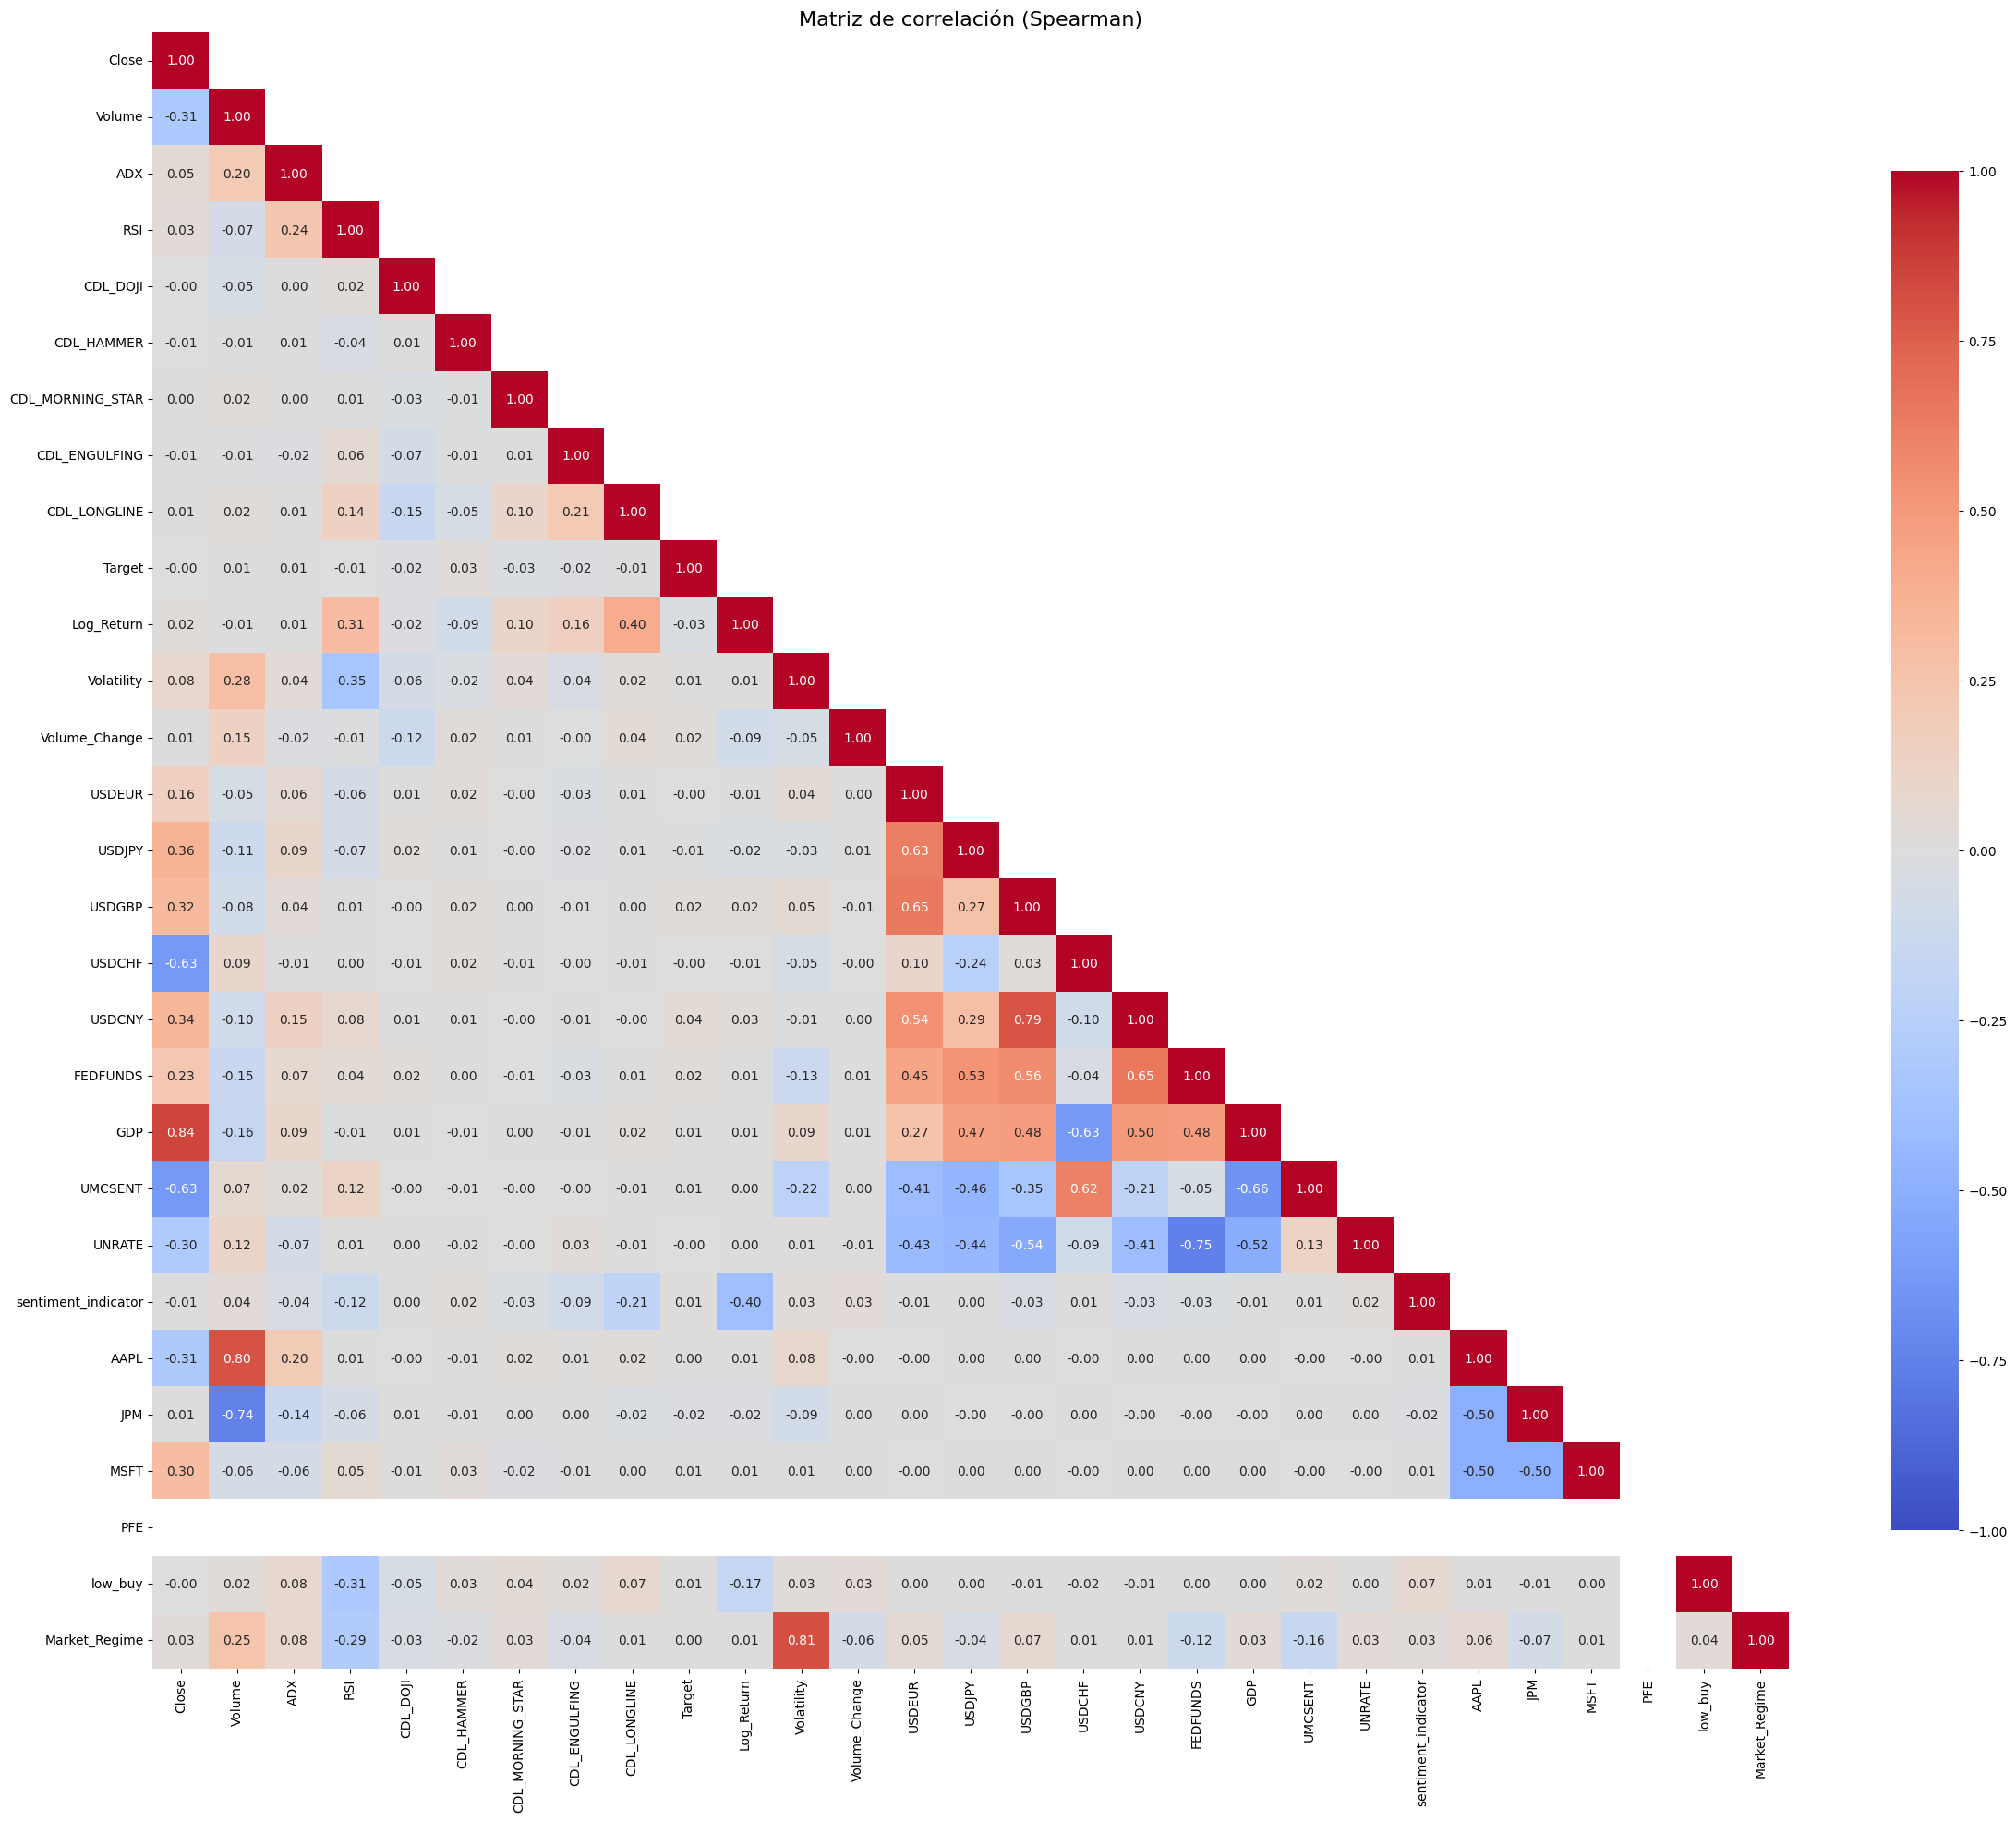

Correlaciones mayores al umbral especificado:
GDP y Close tienen una correlación de 0.84
Market_Regime y Volatility tienen una correlación de 0.81
AAPL y Volume tienen una correlación de 0.80
Forma de X_train_combined después de reshape: (6990, 1, 27)
Forma de y_train_combined: (6990,)
Forma de X_test_combined después de reshape: (69, 1, 27)
Forma de y_test_combined: (69,)


In [26]:
# Dividimos el conjunto de datos en entrenamiento y prueba y procesamos por separado
train, test = split_train_test(final_df, tickers_random)
tickers_train = tickers_random[:-1]
ticker_test = tickers_random[-1]

# Diccionarios para almacenar los datos escalados y los splits
X_train_splits = {}
y_train_splits = {}

if problem == 'clasificacion':
    save_train_test(train, test, train_filename='./train_classification.csv',
                    test_filename='./test_classification.csv')
    df_train = process_data(pd.read_csv(
        './train_classification.csv', sep=';', decimal='.'), df_name="df_train")
    df_test = process_data(pd.read_csv(
        './test_classification.csv', sep=';', decimal='.'), df_name="df_test")
    X_train, y_train, X_test, y_test = split_data_classification(
        df_train, df_test)
    check_class_balance(y_train, y_test)
    X_train_scaled_, X_test_scaled_, y_test = scale_data_classification(
        X_train, X_test, y_train, y_test, df_train, df_test, tickers_train, ticker_test)
    # Aplicamos Walk-Forward Validation a cada acción de entrenamiento
    for ticker in tickers_train:
        X_train_splits[ticker] = walk_forward_validation(X_train_scaled_[
            ticker], y_train[df_train[ticker] == 1], initial_train_size=200, step_size=30)

elif problem == 'regresion':
    save_train_test(
        train, test, train_filename='./train_regression.csv', test_filename='./test_regression.csv')
    df_train = process_data(pd.read_csv(
        './train_regression.csv', sep=';', decimal='.'), df_name="df_train")
    df_test = process_data(pd.read_csv(
        './test_regression.csv', sep=';', decimal='.'), df_name="df_test")
    X_train, y_train, X_test, y_test = split_data_regression(
        df_train, df_test)
    X_train_scaled_, X_test_scaled_, y_train_scaled_, y_test_scaled_, scaler_y_test = scale_data_regression(
        X_train, X_test, y_train, y_test, df_train, df_test, tickers_train, ticker_test)
    # Aplicamos Walk-Forward Validation a cada acción de entrenamiento
    for ticker in tickers_train:
        X_train_splits[ticker] = walk_forward_validation(X_train_scaled_[
            ticker], y_train_scaled_[ticker], initial_train_size=200, step_size=30)

# Visualizamos las correlaciones y listamos correlaciones altas
corr_matrix, high_correlations = process_and_show_correlations(df_train)

# Combinamos los splits de las acciones de entrenamiento
train_splits_combined = []
num_splits = len(X_train_splits[tickers_train[0]])

for i in range(num_splits):  # Iterar sobre cada split
    # Concatenamos los splits de cada acción (X_train, X_test, y_train, y_test)
    X_train_combined = np.concatenate(
        [X_train_splits[ticker][i][0] for ticker in tickers_train])
    X_test_combined = np.concatenate(
        [X_train_splits[ticker][i][1] for ticker in tickers_train])
    y_train_combined = np.concatenate(
        [X_train_splits[ticker][i][2] for ticker in tickers_train])
    y_test_combined = np.concatenate(
        [X_train_splits[ticker][i][3] for ticker in tickers_train])

    train_splits_combined.append(
        (X_train_combined, X_test_combined, y_train_combined, y_test_combined))

# Asegurarnos de que las dimensiones de entrada sean (samples, 1, features) para redes neuronales
X_train_combined_reshaped = X_train_combined.reshape(
    X_train_combined.shape[0], 1, X_train_combined.shape[1])
X_test_combined_reshaped = X_test_combined.reshape(
    X_test_combined.shape[0], 1, X_test_combined.shape[1])

# Imprimimos formas de los datos escalados combinados
print(
    f"Forma de X_train_combined después de reshape: {X_train_combined_reshaped.shape}")
print(f"Forma de y_train_combined: {y_train_combined.shape}")
print(
    f"Forma de X_test_combined después de reshape: {X_test_combined_reshaped.shape}")
print(f"Forma de y_test_combined: {y_test_combined.shape}")

### Modelos y Backtesting: Podemos entrenar de cero o cargar los modelos preentrenados previamente

¿Deseas hacer las predicciones de PFE? (si/no):  si


Random Forest Entrenamiento - Average Accuracy (RF): 0.5163
Random Forest Entrenamiento - Average Precision (RF): 0.5409
Random Forest Entrenamiento - Average Recall (RF): 0.6881
Random Forest Entrenamiento - Average F1 Score (RF): 0.5682
Classification Report Test - PFE (Random Forest):
              precision    recall  f1-score   support

           0       0.54      0.46      0.50       628
           1       0.47      0.54      0.51       549

    accuracy                           0.50      1177
   macro avg       0.50      0.50      0.50      1177
weighted avg       0.51      0.50      0.50      1177

Confusion Matrix Test - PFE (Random Forest):
[[292 336]
 [250 299]]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/stepWARNING:tensorflow:6 out of the last 44 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f8d4e877700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━

Classification Report Test - PFE (Conv1D):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       628
           1       0.47      1.00      0.64       549

    accuracy                           0.47      1177
   macro avg       0.23      0.50      0.32      1177
weighted avg       0.22      0.47      0.30      1177

Confusion Matrix Test - PFE (Conv1D):
[[  0 628]
 [  0 549]]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Confusion Matrix Test - PFE (GRU):
[[171 457]
 [171 378]]
Classification Report Test - PFE (GRU):
              precision    recall  f1-score   support

           0       0.50      0.27      0.35       628
           1       0.45      0.69      0.55       549

    accuracy                           0.47      1177
   macro avg       0.48      0.48      0.45      1177
weighted avg       0.48      0.47      0.44      1177

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

              precision    recall  f1-score   support

           0       0.53      0.39      0.45       628
           1       0.46      0.59      0.52       549

    accuracy                           0.49      1177
   macro avg       0.49      0.49      0.48      1177
weighted avg       0.50      0.49      0.48      1177

Confusion Matrix Test - PFE (LSTM + Random Forest):
[[247 381]
 [223 326]]


Evaluando el modelo: RF - Clasificación - PFE
Evaluando el modelo: Gru - Clasificación - PFE
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Evaluando el modelo: LSTM+RF - Clasificación - PFE
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RF - Clasificación - PFE - Classification Cumulative Return: -9.44%
Gru - Clasificación - PFE - Classification Cumulative Return: -29.83%
LSTM+RF - Clasificación - PFE - Classification Cumulative Return: -33.24%
Buy and Hold Cumulative Return: -22.96%
El mejor modelo es RF - Clasificación - PFE con un retorno acumulado de -9.44%


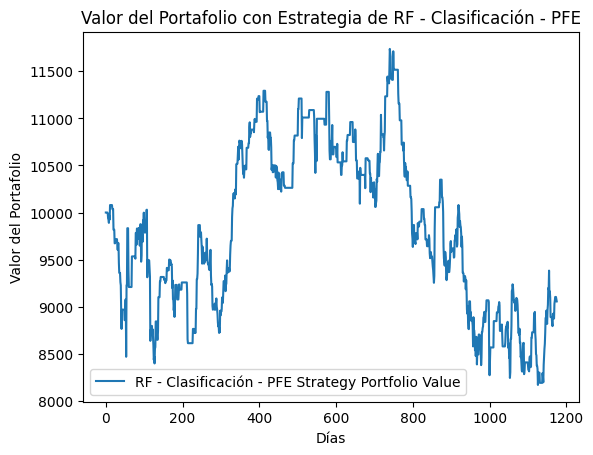

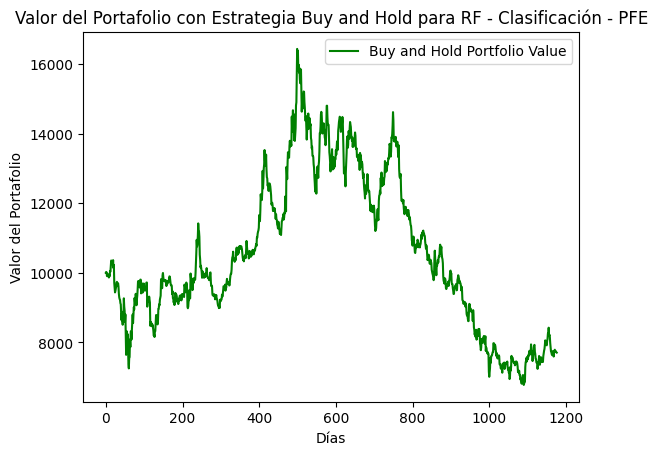

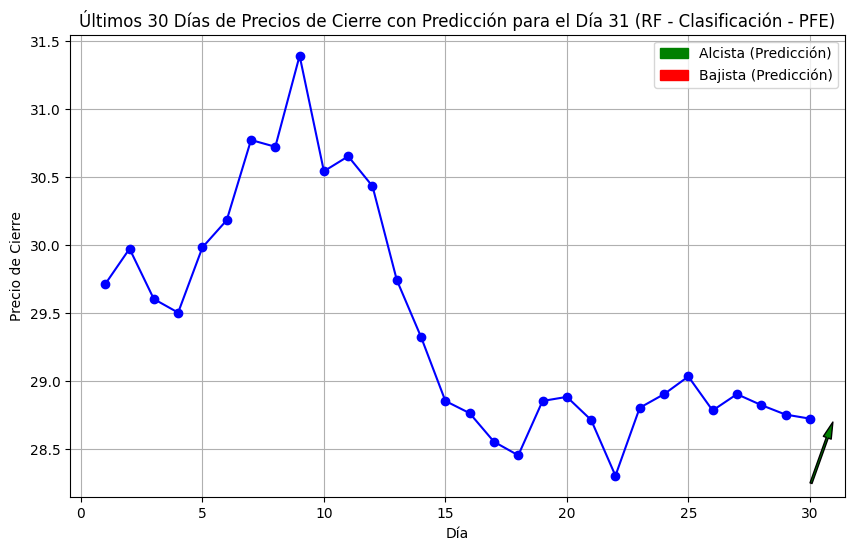

In [30]:
# Preguntamos al usuario si desea realizar las predicciones
hacer_predicciones = input(
    f"¿Deseas hacer las predicciones de {ticker_test}? (si/no): ").strip().lower()

if hacer_predicciones == 'si':

    if problem == 'clasificacion':
        # Llamar a la función para entrenar y evaluar el modelo Random Forest
        rf_model, accuracy_rf, precision_rf, recall_rf, f1_rf, confusion_matrices_rf = train_evaluate_random_forest(
            train_splits_combined, X_test_scaled_, y_test, df_test, ticker_test
        )
        # Llamar a la función para entrenar y evaluar el modelo Conv1D
        conv1d_model, accuracy_conv1d, precision_conv1d, recall_conv1d, f1_conv1d, confusion_matrices_conv1d = train_evaluate_conv1d(
            train_splits_combined, X_test_scaled_, y_test, df_test, ticker_test
        )
        # Llamar a la función para entrenar y evaluar el modelo GRU
        gru_model, accuracy_gru, precision_gru, recall_gru, f1_gru, confusion_matrices_gru = train_evaluate_gru(
            train_splits_combined, X_test_scaled_, y_test, df_test, ticker_test
        )
        # Llamar a la función para entrenar y evaluar el modelo LSTM + Random Forest
        lstm_model, rf_model, accuracy_lstm_rf, precision_lstm_rf, recall_lstm_rf, f1_lstm_rf, confusion_matrices_lstm_rf = train_evaluate_lstm_rf(
            train_splits_combined, X_test_scaled_, y_test, df_test, ticker_test
        )
        # Eliminamos Conv1D directamente por malos resultados
        modelos = {
            f'RF - Clasificación - {ticker_test}': ('', './rf_model_classification.pkl'),
            f'Gru - Clasificación - {ticker_test}': ('./gru_model_classification.h5', ''),
            f'LSTM+RF - Clasificación - {ticker_test}': ('./lstm_model_hybrid_classification.h5', './random_forest_lstm_hybrid_classification.pkl')
        }

        # Evaluamos los modelos y obtenemos el mejor
        best_model, best_portfolio_value_classification, best_buy_and_hold_portfolio_value, best_df_test = evaluar_modelos_clasificacion(
            modelos, df_test, X_test_scaled_, ticker_test
        )

        # Graficamos los resultados del mejor modelo
        graficar_resultados(best_model, best_portfolio_value_classification,
                            best_buy_and_hold_portfolio_value, best_df_test)

    elif problem == 'regresion':
        # Llamar a la función para entrenar y evaluar el modelo LSTM de regresión
        model_lstm, mse_results, r2_results, sharpe_ratios, drawdowns = train_evaluate_lstm_regression(
            train_splits_combined, X_test_scaled_, y_test_scaled_, df_test, ticker_test, scaler_y_test
        )
        # Llamar a la función para entrenar y evaluar el modelo Random Forest
        f_model, mse_results, r2_results, sharpe_ratios, drawdowns = train_evaluate_rf_regression(
           train_splits_combined, X_test_scaled_, y_test_scaled_, df_test, ticker_test, scaler_y_test
        )
        # Llamar a la función para entrenar y evaluar el modelo GRU
        model_gru, mse_results_gru, r2_results_gru, sharpe_ratios_gru, drawdowns_gru = train_evaluate_gru_regression(
            train_splits_combined, X_test_scaled_, y_test_scaled_, df_test, ticker_test, scaler_y_test
        )
        # Llamar a la función para entrenar y evaluar el modelo híbrido GRU + Random Forest
        model_gru, rf_model, mse_results_hybrid, r2_results_hybrid, sharpe_ratios_hybrid, drawdowns_hybrid = train_evaluate_gru_rf_regression(
            train_splits_combined, X_test_scaled_, y_test_scaled_, df_test, ticker_test, scaler_y_test
        )
        # Eliminamos GRU+RF directamente por malos resultados
        modelos = {
            f'GRU - Regresión - {ticker_test}': ('./gru_model_regression.h5', ''),
            f'LSTM - Regresión - {ticker_test}': ('./lstm_model_regression.h5', ''),
            f'RF - Regresión - {ticker_test}': ('', './rf_model_regression.pkl')
        }

        # Evaluamos los modelos de regresión
        best_model, best_portfolio_value, best_buy_and_hold_value, best_df_test, best_pred_31 = evaluar_modelos_regresion(
            modelos, df_test, X_test_scaled_, ticker_test
        )

        # Graficamos los resultados del mejor modelo de regresión
        graficar_resultados_regresion(
            best_model, best_portfolio_value, best_buy_and_hold_value, best_df_test, best_pred_31)

elif hacer_predicciones == 'no':
    # Si el usuario elige "no", cargamos los modelos guardados y ejecutamos solo el backtesting
    if problem == 'clasificacion':
        modelos = {
            f'RF - Clasificación - {ticker_test}': ('', './rf_model_classification_EXPO.pkl'),
            f'GRU - Clasificación - {ticker_test}': ('./gru_model_classification_EXPO.h5', ''),
            f'LSTM+RF - Clasificación - {ticker_test}': ('./lstm_model_hybrid_classification_EXPO.h5', './random_forest_lstm_hybrid_classification_EXPO.pkl')
        }
        best_model, best_portfolio_value_classification, best_buy_and_hold_portfolio_value, best_df_test = evaluar_modelos_clasificacion(
            modelos, df_test, X_test_scaled_, ticker_test
        )
        graficar_resultados(best_model, best_portfolio_value_classification,
                            best_buy_and_hold_portfolio_value, best_df_test)
    elif problem == 'regresion':
        modelos = {
            f'GRU - Regresión - {ticker_test}': ('./gru_model_regression_EXPO.h5', ''),
            f'LSTM - Regresión - {ticker_test}': ('./lstm_model_regression_EXPO.h5', ''),
            f'RF - Regresión - {ticker_test}': ('', './rf_model_regression_EXPO.pkl')
        }
        best_model, best_portfolio_value, best_buy_and_hold_value, best_df_test, best_pred_31 = evaluar_modelos_regresion(
            modelos, df_test, X_test_scaled_, ticker_test
        )
        graficar_resultados_regresion(
            best_model, best_portfolio_value, best_buy_and_hold_value, best_df_test, best_pred_31)